# Setup the PEST(++) interface around the modified Freyberg model

In this notebook, we will construct a complex model independent (non-intrusive) interface around an existing `MODFLOW6` model using `pyEMU`. We assume that the reader is at least partially familiar with PEST(++) file formats and working philosophy. 

The modified Freyberg groundwater flow model has been constructed and is described in a previous notebook from this series. We will construct the entire PEST(++) interface from scratch here. This setup will be built upon in subsequent tutorials. 

We will rely heavily on the `pyemu.PstFrom` class. Although here we employ it with a `MODFLOW6` model, `PstFrom` is designed to be general and software independent (mostly). Some features are only available for `MODFLOW` models (e.g. `SpatialReference`).

The `PstFrom` class automates the construction of high-dimensional PEST(++) interfaces with all the bells and whistles. It provides easy-to-use functions to process model input and output files into PEST(++) datasets. It can assist with setting up spatio-temporaly varying parameters. It handles the generation of geostatisical prior covariance matrices and ensembles. It automates writting a "model run" script. It provides tools to add custom pre- and post-processing functions to this script. It makes adding tweaks and fixes to the PEST(++) interface a breeze. All of this from the comfort of your favourite Python IDE.

During this tutorial we are going to construct a PEST dataset. Amongst other things, we will demonstrate:
 - how to add observations & parameters from model output & input files;
 - how to add pre- and post-processing functions to the "model run" script;
 - how to generate geostatistical structures for spatialy and temporally correlated parameters;
 - how to edit parameter/observation data sections;
 - how to generate a prior parameter covariance matrix and prior parameter ensemble;



First, let's get our model files and sort out some admin.


### 1. Admin & Organize Folders
First some admin. Load the dependencies and organize model folders. 

In [1]:
import sys
import os
import shutil
import platform
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pyemu
import flopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;

We will be calling a few external programs throughout this tutorial. Namely, MODFLOW 6 and PEST++GLM. For the purposes of the tutorial(s), we have included executables in the tutorial repository. They are in the `bin` folder. 

Preferably, executables should be located in a folder that is cited in your computer’s PATH environment variable. Doing so allows you to run them from a command prompt open to any other folder without having to include the full path to these executables in the command to run them. 

Sometimes this may not be practical. In such cases, we can simply place the executables in the folder from which they will be executed.  So, let's copy the necessary executables into our working folder:


In [2]:
# specify a temporary folder; we will gather all our model and executable files here first
# this is to ensure we don't mess up our original model files
tmp_d = os.path.join('freyberg_mf6')

# get the necessary executables; OS agnostic
bin_dir = os.path.join('..','..','bin')

if "window" in platform.platform().lower():
    exe_files = [f for f in os.listdir(bin_dir) if f.endswith('exe')]
else:
    exe_files = [f for f in os.listdir(bin_dir) if not f.endswith('exe')]

# remove existing folder if it already exists
if os.path.exists(tmp_d):
    shutil.rmtree(tmp_d)

# make the folder
os.mkdir(tmp_d)

# copy executables across
for exe_file in exe_files:
    shutil.copy2(os.path.join(bin_dir, exe_file),os.path.join(tmp_d,exe_file))

Let's copy the original model folder into a new working directory, just to ensure we don't mess up the base files.

In [3]:
# folder containing original model files
org_d = os.path.join('..', '..', 'models', 'freyberg_mf6')

# copy files across to the temp folder
for f in os.listdir(org_d):
    shutil.copy2(os.path.join(org_d,f), os.path.join(tmp_d,f))

If you inspect the model folder, you will see that all the `MODFLOW6` model files have been written "externally". This is key for working with the `PstFrom` class (or with PEST(++) in general, really). Essentialy, all pertinent model inputs have been written as independent files in either array or list format. This makes it easier for us to programiatically access and re-write the values in these files.

Array files contain a data type (usually floating points). List files will have a few columns that contain index information and then columns of floating point values (they have a tabular format; think `.csv` files or DataFrames). The `PstFrom` class provides methods for processing these file types into a PEST(++) dataset. 



In [4]:
os.listdir(tmp_d)

['freyberg6.dis',
 'freyberg6.dis.grb',
 'freyberg6.dis_botm_layer1.txt',
 'freyberg6.dis_botm_layer2.txt',
 'freyberg6.dis_botm_layer3.txt',
 'freyberg6.dis_delc.txt',
 'freyberg6.dis_delr.txt',
 'freyberg6.dis_idomain_layer1.txt',
 'freyberg6.dis_idomain_layer2.txt',
 'freyberg6.dis_idomain_layer3.txt',
 'freyberg6.dis_top.txt',
 'freyberg6.ghb',
 'freyberg6.ghb_stress_period_data_1.txt',
 'freyberg6.ic',
 'freyberg6.ic_strt_layer1.txt',
 'freyberg6.ic_strt_layer2.txt',
 'freyberg6.ic_strt_layer3.txt',
 'freyberg6.ims',
 'freyberg6.lst',
 'freyberg6.nam',
 'freyberg6.npf',
 'freyberg6.npf_icelltype_layer1.txt',
 'freyberg6.npf_icelltype_layer2.txt',
 'freyberg6.npf_icelltype_layer3.txt',
 'freyberg6.npf_k33_layer1.txt',
 'freyberg6.npf_k33_layer2.txt',
 'freyberg6.npf_k33_layer3.txt',
 'freyberg6.npf_k_layer1.txt',
 'freyberg6.npf_k_layer2.txt',
 'freyberg6.npf_k_layer3.txt',
 'freyberg6.oc',
 'freyberg6.rch',
 'freyberg6.rch_recharge_1.txt',
 'freyberg6.rch_recharge_10.txt',
 'freyb

Now we need just a tiny bit of info about the spatial discretization of the model - this is needed to work out separation distances between parameters to build a geostatistical prior covariance matrix later.

Here we will load the flopy sim and model instance just to help us define some quantities later - flopy is ***not required*** to use the `PstFrom` class. ***Neither is MODFLOW***. However, at the time of writting, support for `SpatialReference` to spatially locate parameters is limited to MODLOW models.

Load the simulation. Run it once to make sure it works and to ***make sure that model output files are in the folder***. 

In [5]:
# load simulation
sim = flopy.mf6.MFSimulation.load(sim_ws=tmp_d)
# load flow model
gwf = sim.get_model()

# run the model once to make sure it works
sim.run_simulation()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package oc...
    loading package wel...
    loading package rch...
    loading package ghb...


    loading package sfr...


    loading package obs...
  loading ims package freyberg6...
FloPy is using the following executable to run the model: C:\Program Files\MODFLOW\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.2 07/30/2021

   MODFLOW 6 compiled Jul 31 2021 14:57:11 with IFORT compiler (ver. 20.21.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 

    Solving:  Stress period:     1    Time step:     1
    Solving:  Stress period:     2    Time step:     1
    Solving:  Stress period:     3    Time step:     1
    Solving:  Stress period:     4    Time step:     1
    Solving:  Stress period:     5    Time step:     1
    Solving:  Stress period:     6    Time step:     1
    Solving:  Stress period:     7    Time step:     1
    Solving:  Stress period:     8    Time step:     1
    Solving:  Stress period:     9    Time step:     1


    Solving:  Stress period:    10    Time step:     1
    Solving:  Stress period:    11    Time step:     1
    Solving:  Stress period:    12    Time step:     1
    Solving:  Stress period:    13    Time step:     1
    Solving:  Stress period:    14    Time step:     1
    Solving:  Stress period:    15    Time step:     1
    Solving:  Stress period:    16    Time step:     1
    Solving:  Stress period:    17    Time step:     1
    Solving:  Stress period:    18    Time step:     1
    Solving:  Stress period:    19    Time step:     1
    Solving:  Stress period:    20    Time step:     1


    Solving:  Stress period:    21    Time step:     1
    Solving:  Stress period:    22    Time step:     1
    Solving:  Stress period:    23    Time step:     1
    Solving:  Stress period:    24    Time step:     1
    Solving:  Stress period:    25    Time step:     1
 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/03/15 15:50:31
 Elapsed run time:  0.739 Seconds
 
 Normal termination of simulation.


(True, [])

### 2. Spatial Reference
Now we can instantiate a `SpatialReference`. This will later be passed to `PstFrom` to assist with spatially locating parameters (e.g. pilot points and/or cell-by-cell parameters).

In [6]:
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(tmp_d, "freyberg6.nam"),
        delr=gwf.dis.delr.array, delc=gwf.dis.delc.array)

   could not remove start_datetime


### 3. Instantiate PstFrom

Now we can start to construct the PEST(++) interface by instantiating a `PstFrom` class instance. There are a few things that we need to specify up front:

 - the folder in which we currently have model files (e.g. `tmp_d`). PstFrom will copy all the files from this directory into a new "template" folder.
 - **template folder**: this is a folder in which the PEST dataset will be constructed. This folder/dataset will form the template for subsequent deployment of PEST(++). It is **not** where PEST(++) will be run.
 - **longnames**: for backwards compatibility with PEST and PEST_HP (i.e. non-PEST++ versions), which have upper limits to parameter/obsveration names (PEST++ does not). Setting this value to False is only recommended if required. 
 - Whether the model is `zero based` or not.
 - (optional) the **spatial reference**, as previously discussed. This is only requried if using `pyEMU` to define parameter spatial correlation. Alternatively, you can define these yourself or use utilities available in the PEST-suite. 



In [7]:
# specify a template directory (i.e. the PstFrom working folder)
template_ws = os.path.join("freyberg6_template")

# instantiate PstFrom
pf = pyemu.utils.PstFrom(original_d=tmp_d, # where the model is stored
                            new_d=template_ws, # the PEST template folder
                            remove_existing=True, # ensures a clean start
                            longnames=True, # set False if using PEST/PEST_HP
                            spatial_reference=sr, #the spatial reference we generated earlier
                            zero_based=False, # does the MODEL use zero based indices? For example, MODFLOW does NOT
                            start_datetime="1-1-2018") # required when specifying temporal correlation between parameters

2022-03-15 15:50:31.582353 starting: opening PstFrom.log for logging
2022-03-15 15:50:31.583222 starting PstFrom process
2022-03-15 15:50:31.583222 starting: setting up dirs
2022-03-15 15:50:31.583222 starting: removing existing new_d 'freyberg6_template'


2022-03-15 15:50:31.786878 finished: removing existing new_d 'freyberg6_template' took: 0:00:00.203656


2022-03-15 15:50:32.797820 starting: copying original_d 'freyberg_mf6' to new_d 'freyberg6_template'


2022-03-15 15:50:33.628153 finished: copying original_d 'freyberg_mf6' to new_d 'freyberg6_template' took: 0:00:00.830333
2022-03-15 15:50:33.629151 finished: setting up dirs took: 0:00:02.045929


### 4. Observations

We now have a `PstFrom` instance assigned to the variable `pf`. For now it is only an empty container to which we can start adding "observations", "parameters" and other bits and bobs.

Lets start with observations because they are easier. `MODFLOW6` makes life even easier by recording observations in nicely organized .csv files. Isn't that a peach!

#### 4.1 Freyberg Recap
As you may recall from the "*intro to Freyberg*" tutorial, the model is configured to record time series of head at observation wells, and flux at three locations along the river. These are recorded in external .csv files named `heads.csv` and `sfr.csv`, respectively. You should be able to see these files in the model folder.

Recall that each .csv houses records of observation time-series. Outputs are recorded for each simulated stress-period. The model starts with a single steady-state stress-period, followed by 24 monthly transient stress-periods. The steady-state and first 12 transient stress-periods simulate the history-matching period. The last 12 transient stress periods simulate future conditions (i.e. the prediction period).

In [8]:
# check the output csv file names
for i in gwf.obs:
    print(i.output.obs_names)

['sfr.csv']
['heads.csv']


Let's start with the 'heads.csv' file. First load it as a DataFrame to take a look.

As you can see, there are many columns, one for each observation site. Conveniently, * *cough* * they are named according to the cell layer, row and column. Note that at every site, there is an observation in both the top and bottom layer (0_ and 2_). We will make use of this later to create "secondary observations" of head differences between layers...but let's not get distracted.

The values in the *.csv* file were generated by running the model. (***IMPORTANT!***) However, `PstFrom` assumes that values in this file are the *target* observation values, and they will be used to populate the PEST(++) dataset. Now, you can change these values later on if you wish. However, it can get a bit messy. So you either need to populate model output files with the target values, or update values in the PEST(++) dataset later on. Which approach you adopt is up to personal preference and/or specifics of your modelling workflow. 

We will demonstrate both in this notebook.

In [9]:
df = pd.read_csv(os.path.join(template_ws,"heads.csv"),index_col=0)
df.head()

,TRGW_2_2_15,TRGW_2_2_9,TRGW_2_3_8,TRGW_2_9_1,TRGW_2_13_10,TRGW_2_15_16,TRGW_2_21_10,TRGW_2_22_15,TRGW_2_24_4,TRGW_2_26_6,...,TRGW_0_9_1,TRGW_0_13_10,TRGW_0_15_16,TRGW_0_21_10,TRGW_0_22_15,TRGW_0_24_4,TRGW_0_26_6,TRGW_0_29_15,TRGW_0_33_7,TRGW_0_34_10
time,,,,,,,,,,,,,,,,,,,,,
1.0,34.339320,34.581597,34.611207,34.872171,34.257574,34.136387,34.144465,34.027679,34.310857,34.171589,...,34.878082,34.263187,34.141599,34.150067,33.992380,34.316575,34.177206,33.909874,33.985755,33.890192
32.0,34.422684,34.680896,34.712058,34.973141,34.381609,34.245718,34.272721,34.138233,34.437640,34.313791,...,34.978998,34.386488,34.250497,34.277455,34.087585,34.442526,34.318135,33.992787,34.102892,34.005675
61.0,34.496186,34.778508,34.812111,35.083708,34.481942,34.330460,34.376598,34.219319,34.555036,34.427653,...,35.089608,34.487850,34.336217,34.382375,34.158109,34.560492,34.433115,34.058266,34.196067,34.086361
92.0,34.541607,34.848735,34.885189,35.178103,34.536194,34.372437,34.431944,34.257802,34.631805,34.490964,...,35.184255,34.543248,34.379139,34.438943,34.191730,34.638273,34.497733,34.090937,34.244095,34.121186
122.0,34.538213,34.859840,34.898354,35.214761,34.520171,34.353363,34.414553,34.236799,34.634051,34.476152,...,35.221267,34.528011,34.360599,34.422425,34.173799,34.641451,34.483960,34.076498,34.226023,34.095425


#### 4.2 Prepare Observation Files

We will start by populating our "model output" file with measured values. For this synthetic case, we conveniently have observations for all model output times and sites. (These "measured" values were generated using the same model with a randomly generated set of parameters; noise was added to all observations.)

In the next cell we read a .csv that contains measured obsevration values. As it has the exact same structure as our model output file, we can simpy replace the values in the model output file (and re-write it!). In real-world cases this step will likley be a bit more involved.

In [10]:
# read the measured head values
hds_meas = pd.read_csv(os.path.join('..', '..', 'models', 'freyberg_mf6_truth',"heads.meas.csv"),
                    index_col=0)

# re-write the model output .csv file with the measured values
hds_meas.to_csv(os.path.join(template_ws,"heads.csv"))

#### 4.2. Adding Observations

Now that our model output file contains the "target values", we can use the `PstFrom.add_observations()` method to add observations to our `pf` object. This method reads ***list-type*** files. The assumption is that these files are organized in a tabular format. 

We are going to tell `pf` which columns of this file contain observations. Values in these columns will be assigned to *observation values*.

We can also inform it if there is an index column. Values in this column will be included in the *observation names*. 

We could also specify which rows to include as observations. But observations are free...so why not keep them all! 

Let's add observations from `heads.csv`. The first column of this file records the time at which the value is simulated. Let's use that as the index column (this becomes useful later on to post-process results). We want all other columns as observation values.


In [11]:
hds_df = pf.add_observations("heads.csv", # the model output file to read
                            insfile="heads.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hds") #prefix to all observation names; choose something logical and easy o find. We use it later on to select obsevrations

2022-03-15 15:50:33.727079 starting: adding observations from output file heads.csv
2022-03-15 15:50:33.727079 starting: adding observations from tabular output file '['heads.csv']'
2022-03-15 15:50:33.728044 starting: reading list-style file: freyberg6_template\heads.csv
2022-03-15 15:50:33.757661 finished: reading list-style file: freyberg6_template\heads.csv took: 0:00:00.029617
2022-03-15 15:50:33.757661 starting: building insfile for tabular output file heads.csv
2022-03-15 15:50:33.773853 finished: building insfile for tabular output file heads.csv took: 0:00:00.016192
2022-03-15 15:50:33.773853 starting: adding observation from instruction file 'freyberg6_template\heads.csv.ins'
2022-03-15 15:50:33.792475 finished: adding observation from instruction file 'freyberg6_template\heads.csv.ins' took: 0:00:00.018622
2022-03-15 15:50:33.794470 finished: adding observations from tabular output file '['heads.csv']' took: 0:00:00.067391


Let's inspect what we just created. 

We can see that the `.add_observations()` method returned a dataframe with lots of useful info: 

 - the observation names that were formed (see `obsnme` column); note that these inlcude lots of usefull metadata like the column name, index value and so on;
 - the values that were read from `heads.csv` (see `obsval` column); 
 - some generic weights and group names; note that observations are grouped according to the column of the model output .csv. Alternatively, we could have specified a list of observation group names.

In [12]:
hds_df.head()

,obsnme,obsval,weight,obgnme
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450661,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441799,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375622,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323056,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10


At this point, no PEST *control file* has been created, we have simply prepared to add these observations to the control file later. Everything is still only stored in memory. However, a PEST *instruction* file has been created in the template folder (`template_ws`):

In [13]:
[f for f in os.listdir(template_ws) if f.endswith(".ins")]

['heads.csv.ins']

Blimey, wasn't that easy? Automatically assimilating thousands of observations into a PEST dataset becomes a breeze!

Let's quickly do the same thing for the SFR observations.

In [14]:
df = pd.read_csv(os.path.join(template_ws, "sfr.csv"), index_col=0)
df.head()

,HEADWATER,TAILWATER,GAGE_1
time,,,
1.0,-644.10,-477.76,1205.3
32.0,-865.29,-638.26,1636.6
61.0,-1034.00,-764.91,1938.5
92.0,-1118.70,-825.49,2073.6
122.0,-1083.00,-794.89,1983.4


In [15]:
# read the measured  values
meas = pd.read_csv(os.path.join('..', '..', 'models', 'freyberg_mf6_truth',"sfr.meas.csv"),
                    index_col=0)
# re-write the model output .csv file with the measured values
meas.to_csv(os.path.join(template_ws,"sfr.csv"))
# add the observations to pf
sfr_df = pf.add_observations("sfr.csv", # the model output file to read
                            insfile="sfr.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="sfr") #prefix to all observation names

2022-03-15 15:50:33.872677 starting: adding observations from output file sfr.csv
2022-03-15 15:50:33.872677 starting: adding observations from tabular output file '['sfr.csv']'
2022-03-15 15:50:33.872677 starting: reading list-style file: freyberg6_template\sfr.csv
2022-03-15 15:50:33.878668 finished: reading list-style file: freyberg6_template\sfr.csv took: 0:00:00.005991
2022-03-15 15:50:33.878668 starting: building insfile for tabular output file sfr.csv
2022-03-15 15:50:33.885606 finished: building insfile for tabular output file sfr.csv took: 0:00:00.006938
2022-03-15 15:50:33.885606 starting: adding observation from instruction file 'freyberg6_template\sfr.csv.ins'
2022-03-15 15:50:33.894605 finished: adding observation from instruction file 'freyberg6_template\sfr.csv.ins' took: 0:00:00.008999
2022-03-15 15:50:33.895603 finished: adding observations from tabular output file '['sfr.csv']' took: 0:00:00.022926


### 5. Parameters

The `PstFrom.add_parameters()` method reads model input files and adds parameters to the PEST(++) dataset. Parameterisation can be configured in several ways. 

 - model input files can be in array or list format;
 - parameters can be setup as different "types". Values in model input files can (1) each be a separate parameter, (2) be grouped into "zones" or (3) all be treated as a single parameter. Alteratvely, (4) parameters can be assigned to pilot points, from which individual parameter values are subsequently interpolated. `PstFrom` adds the relevant pre-processing steps to assign paramter values directly into the "model run" script.
 - parameter values can be setup as "direct", "multiplier" or "addend". This means the "parameter value" which PEST(++) sees can be (1) the same value the model sees, (2) a multiplier on the value in the model input file, or (3) a value which is added to the value in the model input file. This is very nifty. `PstFrom` is designed to preferentially use parameters setup as multipliers. These let us preserve the existing model inputs and treat them as the mean of the prior parameter distribution. Once again, relevant pre-processing scripts are automatically added to the "model run" script (discussed later).


#### 5.1. Freyberg Recap

As discussed, all model inputs are stored in external files. Some are arrays. Others are lists. Recall that our model has 3 layers. It is transient. Hydraulic properties (Kh, Kv, Ss, Sy) vary in space. Recharge varies over both space and time. We have GHBs, SFR and WEL boundary conditions. GHB parameters are constant over time, but vary spatially. SFR inflow varies over time. Pumping rates of individual wells are uncertain in space and and time.

All of these have some degree of spatial and/or temporal correlation.

#### 5.2. Geostatistical Structures

Parameter correlation plays a role in (1) regularization when giving preference to the emergence of patterns of spatial heterogeneity and (2) when specifying the prior parameter probability distribution. Since we are all sophisticated and recognize the importance of expressing spatial and temporal uncertainty (e.g. heterogeneity) in the model inputs (and the corresponding spatial correlation in those uncertain inputs), let's use geostatistics to express uncertainty. To do that we need to define "geostatistical structures". 

For the sake of this tutorial, let's assume that heterogeneity in all spatially distributed parameters share the same statistical characteristics. Likewise for temporally varying parameters. We will therefore only  construct two geostatisitcal structures.

<AxesSubplot:xlabel='distance', ylabel='$\\gamma$'>

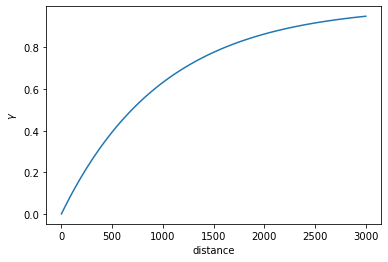

In [16]:
# exponential variogram for spatially varying parameters
v_space = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=1000, # range of correlation; length units of the model. In our case 'meters'
                                    anisotropy=1.0, #name says it all
                                    bearing=0.0 #angle in degrees East of North corresponding to anisotropy ellipse
                                    )

# geostatistical structure for spatially varying parameters
grid_gs = pyemu.geostats.GeoStruct(variograms=v_space, transform='log') 

# plot the gs if you like:
grid_gs.plot()

In [17]:
# exponential variogram for time varying parameters
v_time = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=60, # range of correlation; length time units (days)
                                    anisotropy=1.0, #do not change for 1-D time
                                    bearing=0.0 #do not change for 1-D time
                                    )

# geostatistical structure for time varying parameters
temporal_gs = pyemu.geostats.GeoStruct(variograms=v_time, transform='none') 

#### 5.3. Add Parameters

Let's start by adding parameters of hydraulic properties that vary in space (but not time) and which are housed in array-type files (e.g. Kh, Kv, Ss, Sy). We will start by demonstrating step-by-step for Kh.

First, find all the external array files that contain Kh values. In our case, these are the files with "npf_k_" in the file name. As you can see below, there is one file for each model layer. 

In [18]:
tag = "npf_k_"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
print(files)

['freyberg6.npf_k_layer1.txt', 'freyberg6.npf_k_layer2.txt', 'freyberg6.npf_k_layer3.txt']


Let's setup multiple spatial scales of parameters for Kh. To do this we will use three of the parameter "types" described above. The coarse scale will be a `constant` single value for each array. The medium scale will `pilot points`. The finest scale will use parameters as the `grid` scale (a unique parameter for each model cell!)

Each scale of parameters will work with the others as multipliers with the existing Kh arrays. (This all happens at runtime as part of the "model run" script.) Think of the scales as dials that PEST(++) can turn to improve the fit. The "coarse" scale is one big dial that alows PEST to move everything at once. The "medium" dials are few (but not too many) that allow PEST to adjust broad areas, but not making eveything move. The "fine" scales are lots of small dials that allow PEST(++) to have very detailed control, tweaking parameter values within very small areas. 

However, because we are working with parameter `multipliers`, we will need to specify two sets of parameter bounds: 
 - `upper_bound` and `lower_bound` are the standard control file bounds, while
 - `ult_ubound` and `ult_lbound` are bounds that are applied at runtime to the resulting (multiplied out) model input array. 
 
Since we are using sets of multipliers, it is important to make sure we keep the resulting model input arrays within the range of realistic values.

#### 5.3.1. Array Files

We will first demonstrate steb-by-step for `freyberg6.npf_k_layer1.txt`. We will start with grid scale parameters. These are multipliers assigned to each individual value in the array.

We start by getting the idomain array. As our model has inactive cells, this heps us avoid adding unncessary parameters. It is also required later when generating pilot points.

In [19]:
# as IDOMIAN is the same in all layers, we can use any layer
ib = gwf.dis.idomain.get_data(layer=0)

In [20]:
f = 'freyberg6.npf_k_layer1.txt'

# grid (fine) scale parameters
df_gr = pf.add_parameters(f,
                zone_array=ib, #as we have inactie model cells, we can avoid assigning these as parameters
                par_type="grid", #specify the type, these will be unique parameters for each cell
                geostruct=grid_gs, # the gestatisical structure for spatial correlation 
                par_name_base=f.split('.')[1]+"_gr", #specify a parameter name base that allows us to easily identify the filename and parameter type. "_gr" for "grid", and so forth.
                pargp=f.split('.')[1]+"_gr", #likewise for the parameter group name
                lower_bound=0.2, upper_bound=5.0, #parameter lower and upper bound
                ult_ubound=100, ult_lbound=0.01 # The ultimate bounds for multiplied model input values. Here we are stating that, after accounting for all multipliers, Kh cannot exceed these values. Very important with multipliers
                )

2022-03-15 15:50:34.262274 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2022-03-15 15:50:34.262274 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2022-03-15 15:50:34.270253 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.007979
2022-03-15 15:50:34.270253 loaded array 'freyberg_mf6\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2022-03-15 15:50:34.271250 starting: writing array-style template file 'freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:34.271250 starting: writing template file freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl for ['npf_k_layer1_gr_inst:0']
2022-03-15 15:50:34.287207 finished: writing template file freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl for ['npf_k_layer1_gr_inst:0'] took: 0:00:00.015957
2022-03-15 15:50:34.287207 starting: writing array-based template file 'freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl'
2022-0

As when adding observations,  `pf.add_parameters()` returns a dataframe. Take a look. You may recognize alot of the information that appears in a PEST `*parameter data` section. All of this is still only housed in memory for now. We will write the PEST control file later on.

In [21]:
df_gr.head()

,parnme,parval1,i,j,x,y,pargp,tpl_filename,input_filename,partype,partrans,parubnd,parlbnd,dercom,scale,parchglim,offset
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1,1.0,0,0,125.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,1,1.0,factor,0.0
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1,1.0,0,1,375.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,1,1.0,factor,0.0
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00_zone:1,1.0,0,2,625.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,1,1.0,factor,0.0
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00_zone:1,1.0,0,3,875.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,1,1.0,factor,0.0
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:4_x:1125.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:4_x:1125.00_y:9875.00_zone:1,1.0,0,4,1125.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,1,1.0,factor,0.0


Now, we add pilot point (medium scale) multiplier parameters to the same model input file. These multipliers are assigned to pilot points, which are subsequently interpolated to values in the array.

You can add pilot points in two ways:

1. `PstFrom` can generate them for you on a regular grid or 
2. you can supply `PstFrom` with existing pilot point location information. 

When you change `par_type` to "pilotpoints", by default, a regular grid of pilot points is setup using a default `pp_space` value of 10 (which is every 10th row and column). You can chnge this spacing by passing a integer to `pp_space` (as demonstrated below). 

Alternatively you can specify a filename or dataframe with pilot point locations. If you supply `pp_space` as a `str` it is assumed to be a filename. The extension is the guide: ".csv" for dataframe, ".shp" for shapefile (point-type). Anything else and the file is assumed to be a pilot points file type. The dataframe (or .csv file) must have "name", "x", and "y" as columns - it can have more, but must have those. 

In [22]:
# pilot point (medium) scale parameters
df_pp = pf.add_parameters(f,
                    zone_array=ib,
                    par_type="pilotpoints",
                    geostruct=grid_gs,
                    par_name_base=f.split('.')[1]+"_pp",
                    pargp=f.split('.')[1]+"_pp",
                    lower_bound=0.2,upper_bound=5.0,
                    ult_ubound=100, ult_lbound=0.01,
                    pp_space=4) # `PstFrom` will generate a unifrom grid of pilot points in every 4th row and column

2022-03-15 15:50:34.340745 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2022-03-15 15:50:34.340745 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2022-03-15 15:50:34.342739 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.001994
2022-03-15 15:50:34.342739 loaded array 'freyberg_mf6\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2022-03-15 15:50:34.344769 starting: writing array-style template file 'freyberg6_template\npf_k_layer1_pp_inst0_pilotpoints.csv.tpl'
2022-03-15 15:50:34.344769 starting: setting up pilot point parameters
2022-03-15 15:50:34.344769 No spatial reference (containing cell spacing) passed.
2022-03-15 15:50:34.344769 OK - using spatial reference in parent object.
2022-03-15 15:50:34.420533 32 pilot point parameters created


2022-03-15 15:50:34.420533 pilot point 'pargp':npf_k_layer1_pp
2022-03-15 15:50:34.420533 finished: setting up pilot point parameters took: 0:00:00.075764
2022-03-15 15:50:34.427513 starting: calculating factors for pargp=npf_k_layer1_pp
2022-03-15 15:50:34.427513 saving krige variance file:freyberg6_template\npf_k_layer1_pp_inst0pp.var.dat
2022-03-15 15:50:34.427513 saving krige factors file:freyberg6_template\npf_k_layer1_pp_inst0pp.fac
starting interp point loop for 706 points


starting 0


starting 1


starting 2


starting 3


starting 4


starting 5


starting 6


starting 7


starting 8


starting 9


took 17.264002 seconds
2022-03-15 15:50:51.738336 finished: calculating factors for pargp=npf_k_layer1_pp took: 0:00:17.310823
2022-03-15 15:50:51.738336 starting: writing array-based template file 'freyberg6_template\npf_k_layer1_pp_inst0pp.dat.tpl'
2022-03-15 15:50:51.739332 saving zone array freyberg6_template\npf_k_layer1_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k_layer1_pp_inst0pp.dat.tpl
2022-03-15 15:50:51.744352 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt'] took: 0:00:17.403607


Lastly, add the constant (coarse) parameter multiplier. This is a single multiplier value applied to all values in the array. 

In [23]:
# constant (coarse) scale parameters
df_cst = pf.add_parameters(f,
                    zone_array=ib,
                    par_type="constant",
                    geostruct=grid_gs,
                    par_name_base=f.split('.')[1]+"_cn",
                    pargp=f.split('.')[1]+"_cn",
                    lower_bound=0.2,upper_bound=5.0,
                    ult_ubound=100, ult_lbound=0.01)

2022-03-15 15:50:51.766396 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2022-03-15 15:50:51.766396 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2022-03-15 15:50:51.768433 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.002037
2022-03-15 15:50:51.768433 loaded array 'freyberg_mf6\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2022-03-15 15:50:51.770431 starting: writing array-style template file 'freyberg6_template\npf_k_layer1_cn_inst0_constant.csv.tpl'
2022-03-15 15:50:51.771386 starting: writing template file freyberg6_template\npf_k_layer1_cn_inst0_constant.csv.tpl for ['npf_k_layer1_cn_inst:0']
2022-03-15 15:50:51.779412 finished: writing template file freyberg6_template\npf_k_layer1_cn_inst0_constant.csv.tpl for ['npf_k_layer1_cn_inst:0'] took: 0:00:00.008026
2022-03-15 15:50:51.779412 starting: writing array-based template file 'freyberg6_template\npf_k_layer1_cn_inst0_cons

Let's do that for Kh in the other layers. We are going to be doing this a few times, so lets write a function.

In [24]:
def add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100):
    # grid (fine) scale parameters
    pf.add_parameters(f,
                    zone_array=ib,
                    par_type="grid", #specify the type, these will be unique parameters for each cell
                    geostruct=grid_gs, # the gestatisical structure for spatial correlation 
                    par_name_base=f.split('.')[1]+"_gr", #specify a parameter name base that allows us to easily identify the filename and parameter type. "_gr" for "grid", and so forth.
                    pargp=f.split('.')[1]+"_gr", #likewise for the parameter group name
                    lower_bound=lb, upper_bound=ub, #parameter lower and upper bound
                    ult_ubound=uub, ult_lbound=ulb # The ultimate bounds for multiplied model input values. Here we are stating that, after accounting for all multipliers, Kh cannot exceed these values. Very important with multipliers
                    )
                    
    # pilot point (medium) scale parameters
    pf.add_parameters(f,
                        zone_array=ib,
                        par_type="pilotpoints",
                        geostruct=grid_gs,
                        par_name_base=f.split('.')[1]+"_pp",
                        pargp=f.split('.')[1]+"_pp",
                        lower_bound=lb, upper_bound=ub,
                        ult_ubound=uub, ult_lbound=ulb,
                        pp_space=4) # `PstFrom` will generate a unifrom grid of pilot points in every 4th row and column

    # constant (coarse) scale parameters
    pf.add_parameters(f,
                        zone_array=ib,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=f.split('.')[1]+"_cn",
                        pargp=f.split('.')[1]+"_cn",
                        lower_bound=lb, upper_bound=ub,
                        ult_ubound=uub, ult_lbound=ulb)
    return

In [25]:
for f in files[1:]:
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100)

2022-03-15 15:50:51.813725 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k_layer2.txt']
2022-03-15 15:50:51.813725 starting: loading array freyberg6_template\freyberg6.npf_k_layer2.txt
2022-03-15 15:50:51.825656 finished: loading array freyberg6_template\freyberg6.npf_k_layer2.txt took: 0:00:00.011931
2022-03-15 15:50:51.825656 loaded array 'freyberg_mf6\freyberg6.npf_k_layer2.txt' of shape (40, 20)
2022-03-15 15:50:51.827684 starting: writing array-style template file 'freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:51.827684 starting: writing template file freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl for ['npf_k_layer2_gr_inst:0']
2022-03-15 15:50:51.842477 finished: writing template file freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl for ['npf_k_layer2_gr_inst:0'] took: 0:00:00.014793
2022-03-15 15:50:51.842477 starting: writing array-based template file 'freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl'
2022-0

2022-03-15 15:50:51.929640 32 pilot point parameters created
2022-03-15 15:50:51.929640 pilot point 'pargp':npf_k_layer2_pp
2022-03-15 15:50:51.929640 finished: setting up pilot point parameters took: 0:00:00.076190
2022-03-15 15:50:51.936636 starting: writing array-based template file 'freyberg6_template\npf_k_layer2_pp_inst0pp.dat.tpl'
2022-03-15 15:50:51.936636 saving zone array freyberg6_template\npf_k_layer2_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k_layer2_pp_inst0pp.dat.tpl
2022-03-15 15:50:51.972533 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer2.txt'] took: 0:00:00.122070
2022-03-15 15:50:51.972533 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k_layer2.txt']
2022-03-15 15:50:51.972533 starting: loading array freyberg6_template\freyberg6.npf_k_layer2.txt


2022-03-15 15:50:51.974526 finished: loading array freyberg6_template\freyberg6.npf_k_layer2.txt took: 0:00:00.001993
2022-03-15 15:50:51.974526 loaded array 'freyberg_mf6\freyberg6.npf_k_layer2.txt' of shape (40, 20)
2022-03-15 15:50:51.976503 starting: writing array-style template file 'freyberg6_template\npf_k_layer2_cn_inst0_constant.csv.tpl'
2022-03-15 15:50:51.976503 starting: writing template file freyberg6_template\npf_k_layer2_cn_inst0_constant.csv.tpl for ['npf_k_layer2_cn_inst:0']
2022-03-15 15:50:51.983504 finished: writing template file freyberg6_template\npf_k_layer2_cn_inst0_constant.csv.tpl for ['npf_k_layer2_cn_inst:0'] took: 0:00:00.007001
2022-03-15 15:50:51.984499 starting: writing array-based template file 'freyberg6_template\npf_k_layer2_cn_inst0_constant.csv.tpl'
2022-03-15 15:50:51.984499 saving zone array freyberg6_template\npf_k_layer2_cn_inst0_constant.csv.zone for tpl file freyberg6_template\npf_k_layer2_cn_inst0_constant.csv.tpl
2022-03-15 15:50:51.990433 f

2022-03-15 15:50:52.001457 starting: writing array-style template file 'freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:52.001457 starting: writing template file freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.tpl for ['npf_k_layer3_gr_inst:0']
2022-03-15 15:50:52.013424 finished: writing template file freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.tpl for ['npf_k_layer3_gr_inst:0'] took: 0:00:00.011967
2022-03-15 15:50:52.014389 starting: writing array-based template file 'freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:52.014389 saving zone array freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.zone for tpl file freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.tpl
2022-03-15 15:50:52.021383 finished: adding grid type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt'] took: 0:00:00.030950
2022-03-15 15:50:52.021383 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt']
2022-03-15

2022-03-15 15:50:52.107544 starting: writing array-based template file 'freyberg6_template\npf_k_layer3_pp_inst0pp.dat.tpl'
2022-03-15 15:50:52.108583 saving zone array freyberg6_template\npf_k_layer3_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k_layer3_pp_inst0pp.dat.tpl
2022-03-15 15:50:52.113580 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt'] took: 0:00:00.092197
2022-03-15 15:50:52.113580 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt']
2022-03-15 15:50:52.113580 starting: loading array freyberg6_template\freyberg6.npf_k_layer3.txt
2022-03-15 15:50:52.114578 finished: loading array freyberg6_template\freyberg6.npf_k_layer3.txt took: 0:00:00.000998
2022-03-15 15:50:52.114578 loaded array 'freyberg_mf6\freyberg6.npf_k_layer3.txt' of shape (40, 20)
2022-03-15 15:50:52.116571 starting: writing array-style template file 'freyberg6_template\npf_k_layer3_cn_inst0_constant.csv.tpl'
2022-

Well...hot damn, wasn't that easy? Let's speed through the other array parameter files.

In [26]:
# for Kv
tag = "npf_k33"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
for f in files:
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100)

# for Ss
tag = "sto_ss"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
# only for layer 2 and 3; we aren't monsters
for f in files[1:]: 
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=1e-6, uub=1e-3)

# For Sy
tag = "sto_sy"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
# only for layer 1
f = files[0]
add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=0.4)


2022-03-15 15:50:52.139492 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k33_layer1.txt']
2022-03-15 15:50:52.140456 starting: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt
2022-03-15 15:50:52.147437 finished: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt took: 0:00:00.006981
2022-03-15 15:50:52.147437 loaded array 'freyberg_mf6\freyberg6.npf_k33_layer1.txt' of shape (40, 20)
2022-03-15 15:50:52.150431 starting: writing array-style template file 'freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl'


2022-03-15 15:50:52.151428 starting: writing template file freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl for ['npf_k33_layer1_gr_inst:0']
2022-03-15 15:50:52.164393 finished: writing template file freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl for ['npf_k33_layer1_gr_inst:0'] took: 0:00:00.012965
2022-03-15 15:50:52.164393 starting: writing array-based template file 'freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:52.164393 saving zone array freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.zone for tpl file freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl
2022-03-15 15:50:52.172372 finished: adding grid type m style parameters for file(s) ['freyberg6.npf_k33_layer1.txt'] took: 0:00:00.032880
2022-03-15 15:50:52.172372 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k33_layer1.txt']
2022-03-15 15:50:52.172372 starting: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt
2022-03-15 15:50:52.

2022-03-15 15:50:52.253155 32 pilot point parameters created
2022-03-15 15:50:52.253155 pilot point 'pargp':npf_k33_layer1_pp
2022-03-15 15:50:52.253155 finished: setting up pilot point parameters took: 0:00:00.076743
2022-03-15 15:50:52.259191 starting: writing array-based template file 'freyberg6_template\npf_k33_layer1_pp_inst0pp.dat.tpl'
2022-03-15 15:50:52.260193 saving zone array freyberg6_template\npf_k33_layer1_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k33_layer1_pp_inst0pp.dat.tpl
2022-03-15 15:50:52.265123 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k33_layer1.txt'] took: 0:00:00.092751
2022-03-15 15:50:52.265123 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k33_layer1.txt']
2022-03-15 15:50:52.265123 starting: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt
2022-03-15 15:50:52.267118 finished: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt took: 0:00:00.001995
2022

2022-03-15 15:50:52.292907 starting: writing array-style template file 'freyberg6_template\npf_k33_layer2_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:52.292907 starting: writing template file freyberg6_template\npf_k33_layer2_gr_inst0_grid.csv.tpl for ['npf_k33_layer2_gr_inst:0']
2022-03-15 15:50:52.304874 finished: writing template file freyberg6_template\npf_k33_layer2_gr_inst0_grid.csv.tpl for ['npf_k33_layer2_gr_inst:0'] took: 0:00:00.011967
2022-03-15 15:50:52.305872 starting: writing array-based template file 'freyberg6_template\npf_k33_layer2_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:52.305872 saving zone array freyberg6_template\npf_k33_layer2_gr_inst0_grid.csv.zone for tpl file freyberg6_template\npf_k33_layer2_gr_inst0_grid.csv.tpl
2022-03-15 15:50:52.312904 finished: adding grid type m style parameters for file(s) ['freyberg6.npf_k33_layer2.txt'] took: 0:00:00.029909
2022-03-15 15:50:52.312904 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k33_lay

2022-03-15 15:50:52.403704 32 pilot point parameters created
2022-03-15 15:50:52.404665 pilot point 'pargp':npf_k33_layer2_pp
2022-03-15 15:50:52.404665 finished: setting up pilot point parameters took: 0:00:00.087788
2022-03-15 15:50:52.411683 starting: writing array-based template file 'freyberg6_template\npf_k33_layer2_pp_inst0pp.dat.tpl'
2022-03-15 15:50:52.411683 saving zone array freyberg6_template\npf_k33_layer2_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k33_layer2_pp_inst0pp.dat.tpl
2022-03-15 15:50:52.417663 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k33_layer2.txt'] took: 0:00:00.104759
2022-03-15 15:50:52.417663 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k33_layer2.txt']
2022-03-15 15:50:52.417663 starting: loading array freyberg6_template\freyberg6.npf_k33_layer2.txt
2022-03-15 15:50:52.419661 finished: loading array freyberg6_template\freyberg6.npf_k33_layer2.txt took: 0:00:00.001998
2022

2022-03-15 15:50:52.441618 finished: loading array freyberg6_template\freyberg6.npf_k33_layer3.txt took: 0:00:00.005998
2022-03-15 15:50:52.441618 loaded array 'freyberg_mf6\freyberg6.npf_k33_layer3.txt' of shape (40, 20)
2022-03-15 15:50:52.443616 starting: writing array-style template file 'freyberg6_template\npf_k33_layer3_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:52.443616 starting: writing template file freyberg6_template\npf_k33_layer3_gr_inst0_grid.csv.tpl for ['npf_k33_layer3_gr_inst:0']
2022-03-15 15:50:52.456527 finished: writing template file freyberg6_template\npf_k33_layer3_gr_inst0_grid.csv.tpl for ['npf_k33_layer3_gr_inst:0'] took: 0:00:00.012911
2022-03-15 15:50:52.456527 starting: writing array-based template file 'freyberg6_template\npf_k33_layer3_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:52.456527 saving zone array freyberg6_template\npf_k33_layer3_gr_inst0_grid.csv.zone for tpl file freyberg6_template\npf_k33_layer3_gr_inst0_grid.csv.tpl
2022-03-15 15:50:52.463559 finis

2022-03-15 15:50:52.541299 32 pilot point parameters created
2022-03-15 15:50:52.542339 pilot point 'pargp':npf_k33_layer3_pp
2022-03-15 15:50:52.542339 finished: setting up pilot point parameters took: 0:00:00.074805
2022-03-15 15:50:52.548336 starting: writing array-based template file 'freyberg6_template\npf_k33_layer3_pp_inst0pp.dat.tpl'
2022-03-15 15:50:52.548336 saving zone array freyberg6_template\npf_k33_layer3_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k33_layer3_pp_inst0pp.dat.tpl
2022-03-15 15:50:52.554317 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k33_layer3.txt'] took: 0:00:00.090758
2022-03-15 15:50:52.554317 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k33_layer3.txt']
2022-03-15 15:50:52.554317 starting: loading array freyberg6_template\freyberg6.npf_k33_layer3.txt
2022-03-15 15:50:52.556260 finished: loading array freyberg6_template\freyberg6.npf_k33_layer3.txt took: 0:00:00.001943
2022

2022-03-15 15:50:52.594210 saving zone array freyberg6_template\sto_ss_layer2_gr_inst0_grid.csv.zone for tpl file freyberg6_template\sto_ss_layer2_gr_inst0_grid.csv.tpl
2022-03-15 15:50:52.602171 finished: adding grid type m style parameters for file(s) ['freyberg6.sto_ss_layer2.txt'] took: 0:00:00.029954
2022-03-15 15:50:52.602171 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_ss_layer2.txt']
2022-03-15 15:50:52.602171 starting: loading array freyberg6_template\freyberg6.sto_ss_layer2.txt
2022-03-15 15:50:52.604166 finished: loading array freyberg6_template\freyberg6.sto_ss_layer2.txt took: 0:00:00.001995
2022-03-15 15:50:52.604166 loaded array 'freyberg_mf6\freyberg6.sto_ss_layer2.txt' of shape (40, 20)
2022-03-15 15:50:52.606127 starting: writing array-style template file 'freyberg6_template\sto_ss_layer2_pp_inst0_pilotpoints.csv.tpl'
2022-03-15 15:50:52.606127 starting: setting up pilot point parameters
2022-03-15 15:50:52.606127 No spatial referen

2022-03-15 15:50:52.692747 32 pilot point parameters created
2022-03-15 15:50:52.692747 pilot point 'pargp':sto_ss_layer2_pp
2022-03-15 15:50:52.692747 finished: setting up pilot point parameters took: 0:00:00.086620
2022-03-15 15:50:52.699671 starting: writing array-based template file 'freyberg6_template\sto_ss_layer2_pp_inst0pp.dat.tpl'
2022-03-15 15:50:52.700718 saving zone array freyberg6_template\sto_ss_layer2_pp_inst0pp.dat.zone for tpl file freyberg6_template\sto_ss_layer2_pp_inst0pp.dat.tpl
2022-03-15 15:50:52.705706 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_ss_layer2.txt'] took: 0:00:00.103535
2022-03-15 15:50:52.705706 starting: adding constant type m style parameters for file(s) ['freyberg6.sto_ss_layer2.txt']
2022-03-15 15:50:52.705706 starting: loading array freyberg6_template\freyberg6.sto_ss_layer2.txt
2022-03-15 15:50:52.707700 finished: loading array freyberg6_template\freyberg6.sto_ss_layer2.txt took: 0:00:00.001994
2022-03-15 1

2022-03-15 15:50:52.733007 starting: writing array-style template file 'freyberg6_template\sto_ss_layer3_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:52.733007 starting: writing template file freyberg6_template\sto_ss_layer3_gr_inst0_grid.csv.tpl for ['sto_ss_layer3_gr_inst:0']
2022-03-15 15:50:52.745600 finished: writing template file freyberg6_template\sto_ss_layer3_gr_inst0_grid.csv.tpl for ['sto_ss_layer3_gr_inst:0'] took: 0:00:00.012593
2022-03-15 15:50:52.745600 starting: writing array-based template file 'freyberg6_template\sto_ss_layer3_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:52.745600 saving zone array freyberg6_template\sto_ss_layer3_gr_inst0_grid.csv.zone for tpl file freyberg6_template\sto_ss_layer3_gr_inst0_grid.csv.tpl
2022-03-15 15:50:52.752562 finished: adding grid type m style parameters for file(s) ['freyberg6.sto_ss_layer3.txt'] took: 0:00:00.028904
2022-03-15 15:50:52.753564 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_ss_layer3.txt']


2022-03-15 15:50:52.833364 32 pilot point parameters created
2022-03-15 15:50:52.833364 pilot point 'pargp':sto_ss_layer3_pp
2022-03-15 15:50:52.833364 finished: setting up pilot point parameters took: 0:00:00.076812
2022-03-15 15:50:52.840328 starting: writing array-based template file 'freyberg6_template\sto_ss_layer3_pp_inst0pp.dat.tpl'
2022-03-15 15:50:52.840328 saving zone array freyberg6_template\sto_ss_layer3_pp_inst0pp.dat.zone for tpl file freyberg6_template\sto_ss_layer3_pp_inst0pp.dat.tpl
2022-03-15 15:50:52.846330 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_ss_layer3.txt'] took: 0:00:00.092766
2022-03-15 15:50:52.846330 starting: adding constant type m style parameters for file(s) ['freyberg6.sto_ss_layer3.txt']
2022-03-15 15:50:52.846330 starting: loading array freyberg6_template\freyberg6.sto_ss_layer3.txt
2022-03-15 15:50:52.847275 finished: loading array freyberg6_template\freyberg6.sto_ss_layer3.txt took: 0:00:00.000945
2022-03-15 1

2022-03-15 15:50:52.874204 starting: writing array-style template file 'freyberg6_template\sto_sy_layer1_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:52.874204 starting: writing template file freyberg6_template\sto_sy_layer1_gr_inst0_grid.csv.tpl for ['sto_sy_layer1_gr_inst:0']
2022-03-15 15:50:52.887171 finished: writing template file freyberg6_template\sto_sy_layer1_gr_inst0_grid.csv.tpl for ['sto_sy_layer1_gr_inst:0'] took: 0:00:00.012967
2022-03-15 15:50:52.887171 starting: writing array-based template file 'freyberg6_template\sto_sy_layer1_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:52.888167 saving zone array freyberg6_template\sto_sy_layer1_gr_inst0_grid.csv.zone for tpl file freyberg6_template\sto_sy_layer1_gr_inst0_grid.csv.tpl
2022-03-15 15:50:52.895148 finished: adding grid type m style parameters for file(s) ['freyberg6.sto_sy_layer1.txt'] took: 0:00:00.029921
2022-03-15 15:50:52.895148 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_sy_layer1.txt']


2022-03-15 15:50:52.976929 32 pilot point parameters created
2022-03-15 15:50:52.976929 pilot point 'pargp':sto_sy_layer1_pp
2022-03-15 15:50:52.977978 finished: setting up pilot point parameters took: 0:00:00.078790
2022-03-15 15:50:52.983911 starting: writing array-based template file 'freyberg6_template\sto_sy_layer1_pp_inst0pp.dat.tpl'
2022-03-15 15:50:52.984909 saving zone array freyberg6_template\sto_sy_layer1_pp_inst0pp.dat.zone for tpl file freyberg6_template\sto_sy_layer1_pp_inst0pp.dat.tpl
2022-03-15 15:50:52.989895 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_sy_layer1.txt'] took: 0:00:00.094747
2022-03-15 15:50:52.989895 starting: adding constant type m style parameters for file(s) ['freyberg6.sto_sy_layer1.txt']
2022-03-15 15:50:52.989895 starting: loading array freyberg6_template\freyberg6.sto_sy_layer1.txt
2022-03-15 15:50:52.990945 finished: loading array freyberg6_template\freyberg6.sto_sy_layer1.txt took: 0:00:00.001050
2022-03-15 1

#### 5.3.2. Spatial and Temporal Correlation

Now, you may be thinking "shouldn't recharge have temporal correlation as well?". 

Damn straight it should. Now, this requires a little trickery.

First we need to construct a container of stress period datetimes. (This relies on specifying the start_datetime argument when instantiating `PstFrom`.) These datetime values will specify the postion of parameters on the time-axis.



In [27]:
# build up a container of stress period start datetimes - this will
# be used to specify the datetime of each multipler parameter
start_datetime="1-1-2018"
dts = pd.to_datetime(start_datetime) + pd.to_timedelta(np.cumsum(sim.tdis.perioddata.array["perlen"]),unit='d')

dts

DatetimeIndex(['2018-01-02', '2018-02-02', '2018-03-03', '2018-04-03',
               '2018-05-03', '2018-06-03', '2018-07-03', '2018-08-03',
               '2018-09-03', '2018-10-03', '2018-11-03', '2018-12-03',
               '2019-01-03', '2019-02-03', '2019-03-03', '2019-04-03',
               '2019-05-03', '2019-06-03', '2019-07-03', '2019-08-03',
               '2019-09-03', '2019-10-03', '2019-11-03', '2019-12-03',
               '2020-01-03'],
              dtype='datetime64[ns]', freq=None)

If you use the same parameter group name (`pargp`) and same geostruct, `PstFrom` will treat parameters setup across different calls to `add_parameters()` as correlated.  In this case, we want to express temporal correlation in the recharge multiplier parameters. So, we use the same parameter group names for each stress period data file, and specify the `datetime` and `geostruct` arguments.

Including temporal correlation introduces an additional challenge. Interpolation between points that share a common coordinate creates all types of trouble. We are going to have many parameters during each stress period (a single point on the time-axis). To get around this challenge we need to be a bit sneaky.


First, we will apply the multiple *spatial* scales of parameter multiplers (`constant`, `pilot point` and `grid`) as we did for hyraulic properties. 

Then, we will asign an additional `constant` multiplier parameter for each recharge stress-period file (so, a single multiplier for all recharge paramaters for each stress period). We will specify temporal correlation for these `constant` multipliers. These will all have the same parameter group name, as discussed above. 

In [28]:
# for Recharge; 
tag = "rch_recharge"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
for f in files:
    # the spatial multiplier parameters; just use the same function
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=2e-5, uub=2e-4)
    
    
    # multiplier that includes temporal correlation
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    
    # add the constant parameters (with temporal correlation)
    pf.add_parameters(filenames=f,
                    zone_array=ib,
                    par_type="constant",
                    par_name_base=f.split('.')[1]+"_tcn",
                    pargp=f.split('.')[1]+"_tcn",
                    lower_bound=0.5, upper_bound=1.5,
                    ult_ubound=2e-4, ult_lbound=2e-5,
                    datetime=dts[kper], # this places the parameter value on the "time axis"
                    geostruct=temporal_gs)

2022-03-15 15:50:53.069868 starting: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt']
2022-03-15 15:50:53.070864 starting: loading array freyberg6_template\freyberg6.rch_recharge_1.txt
2022-03-15 15:50:53.078861 finished: loading array freyberg6_template\freyberg6.rch_recharge_1.txt took: 0:00:00.007997
2022-03-15 15:50:53.078861 loaded array 'freyberg_mf6\freyberg6.rch_recharge_1.txt' of shape (40, 20)
2022-03-15 15:50:53.080835 starting: writing array-style template file 'freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:53.080835 starting: writing template file freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.tpl for ['rch_recharge_1_gr_inst:0']
2022-03-15 15:50:53.093769 finished: writing template file freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.tpl for ['rch_recharge_1_gr_inst:0'] took: 0:00:00.012934
2022-03-15 15:50:53.094767 starting: writing array-based template file 'freyberg6_template\rch_recharge_1_gr_inst0_

2022-03-15 15:50:53.189545 starting: writing array-based template file 'freyberg6_template\rch_recharge_1_pp_inst0pp.dat.tpl'
2022-03-15 15:50:53.189545 saving zone array freyberg6_template\rch_recharge_1_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_1_pp_inst0pp.dat.tpl
2022-03-15 15:50:53.195497 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt'] took: 0:00:00.092719
2022-03-15 15:50:53.195497 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt']
2022-03-15 15:50:53.195497 starting: loading array freyberg6_template\freyberg6.rch_recharge_1.txt
2022-03-15 15:50:53.196502 finished: loading array freyberg6_template\freyberg6.rch_recharge_1.txt took: 0:00:00.001005
2022-03-15 15:50:53.197524 loaded array 'freyberg_mf6\freyberg6.rch_recharge_1.txt' of shape (40, 20)
2022-03-15 15:50:53.199713 starting: writing array-style template file 'freyberg6_template\rch_recharge_1_cn_inst0_const

2022-03-15 15:50:53.254340 saving zone array freyberg6_template\rch_recharge_10_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_10_gr_inst0_grid.csv.tpl
2022-03-15 15:50:53.262370 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_10.txt'] took: 0:00:00.029938
2022-03-15 15:50:53.262370 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_10.txt']
2022-03-15 15:50:53.262370 starting: loading array freyberg6_template\freyberg6.rch_recharge_10.txt
2022-03-15 15:50:53.263315 finished: loading array freyberg6_template\freyberg6.rch_recharge_10.txt took: 0:00:00.000945
2022-03-15 15:50:53.263315 loaded array 'freyberg_mf6\freyberg6.rch_recharge_10.txt' of shape (40, 20)
2022-03-15 15:50:53.265309 starting: writing array-style template file 'freyberg6_template\rch_recharge_10_pp_inst0_pilotpoints.csv.tpl'
2022-03-15 15:50:53.266367 starting: setting up pilot point parameters
2022-03-15 15:50:53.266367 No

2022-03-15 15:50:53.373289 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_10.txt']
2022-03-15 15:50:53.373289 starting: loading array freyberg6_template\freyberg6.rch_recharge_10.txt
2022-03-15 15:50:53.375284 finished: loading array freyberg6_template\freyberg6.rch_recharge_10.txt took: 0:00:00.001995
2022-03-15 15:50:53.375284 loaded array 'freyberg_mf6\freyberg6.rch_recharge_10.txt' of shape (40, 20)
2022-03-15 15:50:53.376315 starting: writing array-style template file 'freyberg6_template\rch_recharge_10_tcn_inst0_constant.csv.tpl'
2022-03-15 15:50:53.377279 starting: writing template file freyberg6_template\rch_recharge_10_tcn_inst0_constant.csv.tpl for ['rch_recharge_10_tcn_inst:0']
2022-03-15 15:50:53.386255 finished: writing template file freyberg6_template\rch_recharge_10_tcn_inst0_constant.csv.tpl for ['rch_recharge_10_tcn_inst:0'] took: 0:00:00.008976
2022-03-15 15:50:53.386255 starting: writing array-based template file 'freyberg6_tem

2022-03-15 15:50:53.504939 32 pilot point parameters created
2022-03-15 15:50:53.504939 pilot point 'pargp':rch_recharge_11_pp
2022-03-15 15:50:53.504939 finished: setting up pilot point parameters took: 0:00:00.077759
2022-03-15 15:50:53.511971 starting: writing array-based template file 'freyberg6_template\rch_recharge_11_pp_inst0pp.dat.tpl'
2022-03-15 15:50:53.511971 saving zone array freyberg6_template\rch_recharge_11_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_11_pp_inst0pp.dat.tpl
2022-03-15 15:50:53.517954 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_11.txt'] took: 0:00:00.094765
2022-03-15 15:50:53.517954 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_11.txt']
2022-03-15 15:50:53.517954 starting: loading array freyberg6_template\freyberg6.rch_recharge_11.txt
2022-03-15 15:50:53.518901 finished: loading array freyberg6_template\freyberg6.rch_recharge_11.txt took: 0:00:00.000

2022-03-15 15:50:53.562800 starting: writing array-style template file 'freyberg6_template\rch_recharge_12_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:53.562800 starting: writing template file freyberg6_template\rch_recharge_12_gr_inst0_grid.csv.tpl for ['rch_recharge_12_gr_inst:0']
2022-03-15 15:50:53.575777 finished: writing template file freyberg6_template\rch_recharge_12_gr_inst0_grid.csv.tpl for ['rch_recharge_12_gr_inst:0'] took: 0:00:00.012977
2022-03-15 15:50:53.575777 starting: writing array-based template file 'freyberg6_template\rch_recharge_12_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:53.575777 saving zone array freyberg6_template\rch_recharge_12_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_12_gr_inst0_grid.csv.tpl
2022-03-15 15:50:53.583778 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_12.txt'] took: 0:00:00.029917
2022-03-15 15:50:53.583778 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rc

2022-03-15 15:50:53.688482 saving zone array freyberg6_template\rch_recharge_12_cn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_12_cn_inst0_constant.csv.tpl
2022-03-15 15:50:53.694465 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_12.txt'] took: 0:00:00.017952
2022-03-15 15:50:53.694465 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_12.txt']
2022-03-15 15:50:53.694465 starting: loading array freyberg6_template\freyberg6.rch_recharge_12.txt
2022-03-15 15:50:53.696461 finished: loading array freyberg6_template\freyberg6.rch_recharge_12.txt took: 0:00:00.001996
2022-03-15 15:50:53.696461 loaded array 'freyberg_mf6\freyberg6.rch_recharge_12.txt' of shape (40, 20)
2022-03-15 15:50:53.698455 starting: writing array-style template file 'freyberg6_template\rch_recharge_12_tcn_inst0_constant.csv.tpl'
2022-03-15 15:50:53.698455 starting: writing template file freyberg6_template\rch_recharge_12

2022-03-15 15:50:53.747427 finished: loading array freyberg6_template\freyberg6.rch_recharge_13.txt took: 0:00:00.000977
2022-03-15 15:50:53.747427 loaded array 'freyberg_mf6\freyberg6.rch_recharge_13.txt' of shape (40, 20)
2022-03-15 15:50:53.750439 starting: writing array-style template file 'freyberg6_template\rch_recharge_13_pp_inst0_pilotpoints.csv.tpl'
2022-03-15 15:50:53.750439 starting: setting up pilot point parameters
2022-03-15 15:50:53.750439 No spatial reference (containing cell spacing) passed.
2022-03-15 15:50:53.750439 OK - using spatial reference in parent object.
2022-03-15 15:50:53.838209 32 pilot point parameters created
2022-03-15 15:50:53.838209 pilot point 'pargp':rch_recharge_13_pp
2022-03-15 15:50:53.838209 finished: setting up pilot point parameters took: 0:00:00.087770
2022-03-15 15:50:53.845191 starting: writing array-based template file 'freyberg6_template\rch_recharge_13_pp_inst0pp.dat.tpl'
2022-03-15 15:50:53.845191 saving zone array freyberg6_template\rc

2022-03-15 15:50:53.870159 finished: loading array freyberg6_template\freyberg6.rch_recharge_13.txt took: 0:00:00.001996
2022-03-15 15:50:53.870159 loaded array 'freyberg_mf6\freyberg6.rch_recharge_13.txt' of shape (40, 20)
2022-03-15 15:50:53.872121 starting: writing array-style template file 'freyberg6_template\rch_recharge_13_tcn_inst0_constant.csv.tpl'
2022-03-15 15:50:53.872121 starting: writing template file freyberg6_template\rch_recharge_13_tcn_inst0_constant.csv.tpl for ['rch_recharge_13_tcn_inst:0']
2022-03-15 15:50:53.879134 finished: writing template file freyberg6_template\rch_recharge_13_tcn_inst0_constant.csv.tpl for ['rch_recharge_13_tcn_inst:0'] took: 0:00:00.007013
2022-03-15 15:50:53.879134 starting: writing array-based template file 'freyberg6_template\rch_recharge_13_tcn_inst0_constant.csv.tpl'
2022-03-15 15:50:53.880132 saving zone array freyberg6_template\rch_recharge_13_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_13_tcn_inst0_constan

2022-03-15 15:50:53.997920 32 pilot point parameters created
2022-03-15 15:50:53.997920 pilot point 'pargp':rch_recharge_14_pp
2022-03-15 15:50:53.997920 finished: setting up pilot point parameters took: 0:00:00.077877
2022-03-15 15:50:54.004906 starting: writing array-based template file 'freyberg6_template\rch_recharge_14_pp_inst0pp.dat.tpl'
2022-03-15 15:50:54.004906 saving zone array freyberg6_template\rch_recharge_14_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_14_pp_inst0pp.dat.tpl
2022-03-15 15:50:54.009922 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_14.txt'] took: 0:00:00.092887
2022-03-15 15:50:54.010919 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_14.txt']
2022-03-15 15:50:54.010919 starting: loading array freyberg6_template\freyberg6.rch_recharge_14.txt
2022-03-15 15:50:54.011918 finished: loading array freyberg6_template\freyberg6.rch_recharge_14.txt took: 0:00:00.000

2022-03-15 15:50:54.070501 finished: writing template file freyberg6_template\rch_recharge_15_gr_inst0_grid.csv.tpl for ['rch_recharge_15_gr_inst:0'] took: 0:00:00.013963
2022-03-15 15:50:54.070501 starting: writing array-based template file 'freyberg6_template\rch_recharge_15_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:54.070501 saving zone array freyberg6_template\rch_recharge_15_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_15_gr_inst0_grid.csv.tpl
2022-03-15 15:50:54.078447 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_15.txt'] took: 0:00:00.031625
2022-03-15 15:50:54.078447 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_15.txt']
2022-03-15 15:50:54.078447 starting: loading array freyberg6_template\freyberg6.rch_recharge_15.txt
2022-03-15 15:50:54.079499 finished: loading array freyberg6_template\freyberg6.rch_recharge_15.txt took: 0:00:00.001052
2022-03-15 15:50:54.079499 loaded array

2022-03-15 15:50:54.185161 finished: loading array freyberg6_template\freyberg6.rch_recharge_15.txt took: 0:00:00.001994
2022-03-15 15:50:54.185161 loaded array 'freyberg_mf6\freyberg6.rch_recharge_15.txt' of shape (40, 20)
2022-03-15 15:50:54.187207 starting: writing array-style template file 'freyberg6_template\rch_recharge_15_cn_inst0_constant.csv.tpl'
2022-03-15 15:50:54.187207 starting: writing template file freyberg6_template\rch_recharge_15_cn_inst0_constant.csv.tpl for ['rch_recharge_15_cn_inst:0']
2022-03-15 15:50:54.194138 finished: writing template file freyberg6_template\rch_recharge_15_cn_inst0_constant.csv.tpl for ['rch_recharge_15_cn_inst:0'] took: 0:00:00.006931
2022-03-15 15:50:54.194138 starting: writing array-based template file 'freyberg6_template\rch_recharge_15_cn_inst0_constant.csv.tpl'
2022-03-15 15:50:54.195135 saving zone array freyberg6_template\rch_recharge_15_cn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_15_cn_inst0_constant.csv.tp

2022-03-15 15:50:54.252033 finished: loading array freyberg6_template\freyberg6.rch_recharge_16.txt took: 0:00:00.002045
2022-03-15 15:50:54.252033 loaded array 'freyberg_mf6\freyberg6.rch_recharge_16.txt' of shape (40, 20)
2022-03-15 15:50:54.254028 starting: writing array-style template file 'freyberg6_template\rch_recharge_16_pp_inst0_pilotpoints.csv.tpl'
2022-03-15 15:50:54.254028 starting: setting up pilot point parameters
2022-03-15 15:50:54.254028 No spatial reference (containing cell spacing) passed.
2022-03-15 15:50:54.254028 OK - using spatial reference in parent object.
2022-03-15 15:50:54.331292 32 pilot point parameters created
2022-03-15 15:50:54.331292 pilot point 'pargp':rch_recharge_16_pp
2022-03-15 15:50:54.331292 finished: setting up pilot point parameters took: 0:00:00.077264
2022-03-15 15:50:54.338325 starting: writing array-based template file 'freyberg6_template\rch_recharge_16_pp_inst0pp.dat.tpl'
2022-03-15 15:50:54.338325 saving zone array freyberg6_template\rc

2022-03-15 15:50:54.374176 saving zone array freyberg6_template\rch_recharge_16_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_16_tcn_inst0_constant.csv.tpl
2022-03-15 15:50:54.381183 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_16.txt'] took: 0:00:00.019937
2022-03-15 15:50:54.381183 starting: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_17.txt']
2022-03-15 15:50:54.381183 starting: loading array freyberg6_template\freyberg6.rch_recharge_17.txt
2022-03-15 15:50:54.388193 finished: loading array freyberg6_template\freyberg6.rch_recharge_17.txt took: 0:00:00.007010
2022-03-15 15:50:54.388193 loaded array 'freyberg_mf6\freyberg6.rch_recharge_17.txt' of shape (40, 20)
2022-03-15 15:50:54.390186 starting: writing array-style template file 'freyberg6_template\rch_recharge_17_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:54.390186 starting: writing template file freyberg6_template\rch_recharge_17_gr_ins

2022-03-15 15:50:54.491850 32 pilot point parameters created
2022-03-15 15:50:54.491850 pilot point 'pargp':rch_recharge_17_pp
2022-03-15 15:50:54.492882 finished: setting up pilot point parameters took: 0:00:00.078760
2022-03-15 15:50:54.499834 starting: writing array-based template file 'freyberg6_template\rch_recharge_17_pp_inst0pp.dat.tpl'
2022-03-15 15:50:54.499834 saving zone array freyberg6_template\rch_recharge_17_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_17_pp_inst0pp.dat.tpl
2022-03-15 15:50:54.504817 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_17.txt'] took: 0:00:00.094684
2022-03-15 15:50:54.504817 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_17.txt']
2022-03-15 15:50:54.504817 starting: loading array freyberg6_template\freyberg6.rch_recharge_17.txt
2022-03-15 15:50:54.506863 finished: loading array freyberg6_template\freyberg6.rch_recharge_17.txt took: 0:00:00.002

2022-03-15 15:50:54.565654 saving zone array freyberg6_template\rch_recharge_18_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_18_gr_inst0_grid.csv.tpl
2022-03-15 15:50:54.572686 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_18.txt'] took: 0:00:00.028973
2022-03-15 15:50:54.572686 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_18.txt']
2022-03-15 15:50:54.573696 starting: loading array freyberg6_template\freyberg6.rch_recharge_18.txt
2022-03-15 15:50:54.574630 finished: loading array freyberg6_template\freyberg6.rch_recharge_18.txt took: 0:00:00.000934
2022-03-15 15:50:54.574630 loaded array 'freyberg_mf6\freyberg6.rch_recharge_18.txt' of shape (40, 20)
2022-03-15 15:50:54.576679 starting: writing array-style template file 'freyberg6_template\rch_recharge_18_pp_inst0_pilotpoints.csv.tpl'
2022-03-15 15:50:54.576679 starting: setting up pilot point parameters
2022-03-15 15:50:54.576679 No

2022-03-15 15:50:54.675062 finished: writing template file freyberg6_template\rch_recharge_18_cn_inst0_constant.csv.tpl for ['rch_recharge_18_cn_inst:0'] took: 0:00:00.007929
2022-03-15 15:50:54.675062 starting: writing array-based template file 'freyberg6_template\rch_recharge_18_cn_inst0_constant.csv.tpl'
2022-03-15 15:50:54.675062 saving zone array freyberg6_template\rch_recharge_18_cn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_18_cn_inst0_constant.csv.tpl
2022-03-15 15:50:54.681044 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_18.txt'] took: 0:00:00.017897
2022-03-15 15:50:54.681044 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_18.txt']
2022-03-15 15:50:54.681044 starting: loading array freyberg6_template\freyberg6.rch_recharge_18.txt
2022-03-15 15:50:54.683145 finished: loading array freyberg6_template\freyberg6.rch_recharge_18.txt took: 0:00:00.002101
2022-03-15 15:50:54.68

2022-03-15 15:50:54.745656 OK - using spatial reference in parent object.
2022-03-15 15:50:54.824407 32 pilot point parameters created
2022-03-15 15:50:54.824407 pilot point 'pargp':rch_recharge_19_pp
2022-03-15 15:50:54.824407 finished: setting up pilot point parameters took: 0:00:00.079736
2022-03-15 15:50:54.830390 starting: writing array-based template file 'freyberg6_template\rch_recharge_19_pp_inst0pp.dat.tpl'
2022-03-15 15:50:54.831424 saving zone array freyberg6_template\rch_recharge_19_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_19_pp_inst0pp.dat.tpl
2022-03-15 15:50:54.836416 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_19.txt'] took: 0:00:00.095737
2022-03-15 15:50:54.836416 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_19.txt']
2022-03-15 15:50:54.836416 starting: loading array freyberg6_template\freyberg6.rch_recharge_19.txt
2022-03-15 15:50:54.838406 finished: loadin

2022-03-15 15:50:54.855326 finished: loading array freyberg6_template\freyberg6.rch_recharge_19.txt took: 0:00:00.000966
2022-03-15 15:50:54.855326 loaded array 'freyberg_mf6\freyberg6.rch_recharge_19.txt' of shape (40, 20)
2022-03-15 15:50:54.858317 starting: writing array-style template file 'freyberg6_template\rch_recharge_19_tcn_inst0_constant.csv.tpl'
2022-03-15 15:50:54.858317 starting: writing template file freyberg6_template\rch_recharge_19_tcn_inst0_constant.csv.tpl for ['rch_recharge_19_tcn_inst:0']
2022-03-15 15:50:54.865299 finished: writing template file freyberg6_template\rch_recharge_19_tcn_inst0_constant.csv.tpl for ['rch_recharge_19_tcn_inst:0'] took: 0:00:00.006982
2022-03-15 15:50:54.865299 starting: writing array-based template file 'freyberg6_template\rch_recharge_19_tcn_inst0_constant.csv.tpl'
2022-03-15 15:50:54.866489 saving zone array freyberg6_template\rch_recharge_19_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_19_tcn_inst0_constan

2022-03-15 15:50:54.992233 finished: setting up pilot point parameters took: 0:00:00.086343
2022-03-15 15:50:54.999247 starting: writing array-based template file 'freyberg6_template\rch_recharge_2_pp_inst0pp.dat.tpl'
2022-03-15 15:50:54.999247 saving zone array freyberg6_template\rch_recharge_2_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_2_pp_inst0pp.dat.tpl
2022-03-15 15:50:55.005197 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_2.txt'] took: 0:00:00.102284
2022-03-15 15:50:55.005197 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_2.txt']
2022-03-15 15:50:55.005197 starting: loading array freyberg6_template\freyberg6.rch_recharge_2.txt
2022-03-15 15:50:55.006246 finished: loading array freyberg6_template\freyberg6.rch_recharge_2.txt took: 0:00:00.001049
2022-03-15 15:50:55.006246 loaded array 'freyberg_mf6\freyberg6.rch_recharge_2.txt' of shape (40, 20)
2022-03-15 15:50:55.008190 s

2022-03-15 15:50:55.042157 starting: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_20.txt']
2022-03-15 15:50:55.042157 starting: loading array freyberg6_template\freyberg6.rch_recharge_20.txt
2022-03-15 15:50:55.048134 finished: loading array freyberg6_template\freyberg6.rch_recharge_20.txt took: 0:00:00.005977
2022-03-15 15:50:55.048134 loaded array 'freyberg_mf6\freyberg6.rch_recharge_20.txt' of shape (40, 20)
2022-03-15 15:50:55.051126 starting: writing array-style template file 'freyberg6_template\rch_recharge_20_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:55.051126 starting: writing template file freyberg6_template\rch_recharge_20_gr_inst0_grid.csv.tpl for ['rch_recharge_20_gr_inst:0']
2022-03-15 15:50:55.063094 finished: writing template file freyberg6_template\rch_recharge_20_gr_inst0_grid.csv.tpl for ['rch_recharge_20_gr_inst:0'] took: 0:00:00.011968
2022-03-15 15:50:55.063094 starting: writing array-based template file 'freyberg6_template\rch_recharge_20

2022-03-15 15:50:55.185664 saving zone array freyberg6_template\rch_recharge_20_cn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_20_cn_inst0_constant.csv.tpl
2022-03-15 15:50:55.191643 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_20.txt'] took: 0:00:00.018440
2022-03-15 15:50:55.191643 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_20.txt']
2022-03-15 15:50:55.191643 starting: loading array freyberg6_template\freyberg6.rch_recharge_20.txt
2022-03-15 15:50:55.193639 finished: loading array freyberg6_template\freyberg6.rch_recharge_20.txt took: 0:00:00.001996
2022-03-15 15:50:55.193639 loaded array 'freyberg_mf6\freyberg6.rch_recharge_20.txt' of shape (40, 20)
2022-03-15 15:50:55.195667 starting: writing array-style template file 'freyberg6_template\rch_recharge_20_tcn_inst0_constant.csv.tpl'
2022-03-15 15:50:55.195667 starting: writing template file freyberg6_template\rch_recharge_20

2022-03-15 15:50:55.234601 saving zone array freyberg6_template\rch_recharge_21_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_21_gr_inst0_grid.csv.tpl
2022-03-15 15:50:55.241636 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_21.txt'] took: 0:00:00.031042
2022-03-15 15:50:55.241636 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_21.txt']
2022-03-15 15:50:55.241636 starting: loading array freyberg6_template\freyberg6.rch_recharge_21.txt
2022-03-15 15:50:55.243632 finished: loading array freyberg6_template\freyberg6.rch_recharge_21.txt took: 0:00:00.001996
2022-03-15 15:50:55.243632 loaded array 'freyberg_mf6\freyberg6.rch_recharge_21.txt' of shape (40, 20)
2022-03-15 15:50:55.245572 starting: writing array-style template file 'freyberg6_template\rch_recharge_21_pp_inst0_pilotpoints.csv.tpl'
2022-03-15 15:50:55.245572 starting: setting up pilot point parameters
2022-03-15 15:50:55.245572 No

2022-03-15 15:50:55.380267 finished: loading array freyberg6_template\freyberg6.rch_recharge_22.txt took: 0:00:00.006998
2022-03-15 15:50:55.380267 loaded array 'freyberg_mf6\freyberg6.rch_recharge_22.txt' of shape (40, 20)
2022-03-15 15:50:55.382259 starting: writing array-style template file 'freyberg6_template\rch_recharge_22_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:55.382259 starting: writing template file freyberg6_template\rch_recharge_22_gr_inst0_grid.csv.tpl for ['rch_recharge_22_gr_inst:0']
2022-03-15 15:50:55.395171 finished: writing template file freyberg6_template\rch_recharge_22_gr_inst0_grid.csv.tpl for ['rch_recharge_22_gr_inst:0'] took: 0:00:00.012912
2022-03-15 15:50:55.395171 starting: writing array-based template file 'freyberg6_template\rch_recharge_22_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:55.395171 saving zone array freyberg6_template\rch_recharge_22_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_22_gr_inst0_grid.csv.tpl
2022-03-15 15:50:55.40

2022-03-15 15:50:55.493907 32 pilot point parameters created
2022-03-15 15:50:55.493907 pilot point 'pargp':rch_recharge_22_pp
2022-03-15 15:50:55.493907 finished: setting up pilot point parameters took: 0:00:00.087727
2022-03-15 15:50:55.500888 starting: writing array-based template file 'freyberg6_template\rch_recharge_22_pp_inst0pp.dat.tpl'
2022-03-15 15:50:55.500888 saving zone array freyberg6_template\rch_recharge_22_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_22_pp_inst0pp.dat.tpl
2022-03-15 15:50:55.505912 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_22.txt'] took: 0:00:00.103705
2022-03-15 15:50:55.505912 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_22.txt']
2022-03-15 15:50:55.505912 starting: loading array freyberg6_template\freyberg6.rch_recharge_22.txt
2022-03-15 15:50:55.507904 finished: loading array freyberg6_template\freyberg6.rch_recharge_22.txt took: 0:00:00.001

2022-03-15 15:50:55.572731 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_23.txt'] took: 0:00:00.029919
2022-03-15 15:50:55.572731 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_23.txt']
2022-03-15 15:50:55.572731 starting: loading array freyberg6_template\freyberg6.rch_recharge_23.txt
2022-03-15 15:50:55.574729 finished: loading array freyberg6_template\freyberg6.rch_recharge_23.txt took: 0:00:00.001998
2022-03-15 15:50:55.574729 loaded array 'freyberg_mf6\freyberg6.rch_recharge_23.txt' of shape (40, 20)
2022-03-15 15:50:55.576686 starting: writing array-style template file 'freyberg6_template\rch_recharge_23_pp_inst0_pilotpoints.csv.tpl'
2022-03-15 15:50:55.576686 starting: setting up pilot point parameters
2022-03-15 15:50:55.576686 No spatial reference (containing cell spacing) passed.
2022-03-15 15:50:55.576686 OK - using spatial reference in parent object.
2022-03-15 15:50:55.650388 32 pilot point para

2022-03-15 15:50:55.681338 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_23.txt']
2022-03-15 15:50:55.681338 starting: loading array freyberg6_template\freyberg6.rch_recharge_23.txt
2022-03-15 15:50:55.683301 finished: loading array freyberg6_template\freyberg6.rch_recharge_23.txt took: 0:00:00.001963
2022-03-15 15:50:55.683301 loaded array 'freyberg_mf6\freyberg6.rch_recharge_23.txt' of shape (40, 20)
2022-03-15 15:50:55.685294 starting: writing array-style template file 'freyberg6_template\rch_recharge_23_tcn_inst0_constant.csv.tpl'
2022-03-15 15:50:55.685294 starting: writing template file freyberg6_template\rch_recharge_23_tcn_inst0_constant.csv.tpl for ['rch_recharge_23_tcn_inst:0']
2022-03-15 15:50:55.692276 finished: writing template file freyberg6_template\rch_recharge_23_tcn_inst0_constant.csv.tpl for ['rch_recharge_23_tcn_inst:0'] took: 0:00:00.006982
2022-03-15 15:50:55.692276 starting: writing array-based template file 'freyberg6_tem

2022-03-15 15:50:55.820626 32 pilot point parameters created
2022-03-15 15:50:55.821648 pilot point 'pargp':rch_recharge_24_pp
2022-03-15 15:50:55.821648 finished: setting up pilot point parameters took: 0:00:00.087432
2022-03-15 15:50:55.828637 starting: writing array-based template file 'freyberg6_template\rch_recharge_24_pp_inst0pp.dat.tpl'
2022-03-15 15:50:55.828637 saving zone array freyberg6_template\rch_recharge_24_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_24_pp_inst0pp.dat.tpl
2022-03-15 15:50:55.834630 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_24.txt'] took: 0:00:00.104455
2022-03-15 15:50:55.834630 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_24.txt']
2022-03-15 15:50:55.834630 starting: loading array freyberg6_template\freyberg6.rch_recharge_24.txt
2022-03-15 15:50:55.835618 finished: loading array freyberg6_template\freyberg6.rch_recharge_24.txt took: 0:00:00.000

2022-03-15 15:50:55.878522 finished: loading array freyberg6_template\freyberg6.rch_recharge_25.txt took: 0:00:00.006999
2022-03-15 15:50:55.878522 loaded array 'freyberg_mf6\freyberg6.rch_recharge_25.txt' of shape (40, 20)
2022-03-15 15:50:55.880517 starting: writing array-style template file 'freyberg6_template\rch_recharge_25_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:55.880517 starting: writing template file freyberg6_template\rch_recharge_25_gr_inst0_grid.csv.tpl for ['rch_recharge_25_gr_inst:0']
2022-03-15 15:50:55.892448 finished: writing template file freyberg6_template\rch_recharge_25_gr_inst0_grid.csv.tpl for ['rch_recharge_25_gr_inst:0'] took: 0:00:00.011931
2022-03-15 15:50:55.893464 starting: writing array-based template file 'freyberg6_template\rch_recharge_25_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:55.893464 saving zone array freyberg6_template\rch_recharge_25_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_25_gr_inst0_grid.csv.tpl
2022-03-15 15:50:55.90

2022-03-15 15:50:56.013144 finished: loading array freyberg6_template\freyberg6.rch_recharge_25.txt took: 0:00:00.000991
2022-03-15 15:50:56.014140 loaded array 'freyberg_mf6\freyberg6.rch_recharge_25.txt' of shape (40, 20)
2022-03-15 15:50:56.016136 starting: writing array-style template file 'freyberg6_template\rch_recharge_25_tcn_inst0_constant.csv.tpl'
2022-03-15 15:50:56.016136 starting: writing template file freyberg6_template\rch_recharge_25_tcn_inst0_constant.csv.tpl for ['rch_recharge_25_tcn_inst:0']
2022-03-15 15:50:56.023130 finished: writing template file freyberg6_template\rch_recharge_25_tcn_inst0_constant.csv.tpl for ['rch_recharge_25_tcn_inst:0'] took: 0:00:00.006994
2022-03-15 15:50:56.023130 starting: writing array-based template file 'freyberg6_template\rch_recharge_25_tcn_inst0_constant.csv.tpl'
2022-03-15 15:50:56.024082 saving zone array freyberg6_template\rch_recharge_25_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_25_tcn_inst0_constan

2022-03-15 15:50:56.063004 finished: loading array freyberg6_template\freyberg6.rch_recharge_3.txt took: 0:00:00.002022
2022-03-15 15:50:56.063004 loaded array 'freyberg_mf6\freyberg6.rch_recharge_3.txt' of shape (40, 20)
2022-03-15 15:50:56.065006 starting: writing array-style template file 'freyberg6_template\rch_recharge_3_pp_inst0_pilotpoints.csv.tpl'
2022-03-15 15:50:56.065006 starting: setting up pilot point parameters
2022-03-15 15:50:56.065006 No spatial reference (containing cell spacing) passed.
2022-03-15 15:50:56.065006 OK - using spatial reference in parent object.
2022-03-15 15:50:56.141810 32 pilot point parameters created
2022-03-15 15:50:56.141810 pilot point 'pargp':rch_recharge_3_pp
2022-03-15 15:50:56.141810 finished: setting up pilot point parameters took: 0:00:00.076804
2022-03-15 15:50:56.148792 starting: writing array-based template file 'freyberg6_template\rch_recharge_3_pp_inst0pp.dat.tpl'
2022-03-15 15:50:56.148792 saving zone array freyberg6_template\rch_rec

2022-03-15 15:50:56.200619 starting: writing array-style template file 'freyberg6_template\rch_recharge_4_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:56.200619 starting: writing template file freyberg6_template\rch_recharge_4_gr_inst0_grid.csv.tpl for ['rch_recharge_4_gr_inst:0']
2022-03-15 15:50:56.213618 finished: writing template file freyberg6_template\rch_recharge_4_gr_inst0_grid.csv.tpl for ['rch_recharge_4_gr_inst:0'] took: 0:00:00.012999
2022-03-15 15:50:56.213618 starting: writing array-based template file 'freyberg6_template\rch_recharge_4_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:56.213618 saving zone array freyberg6_template\rch_recharge_4_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_4_gr_inst0_grid.csv.tpl
2022-03-15 15:50:56.220600 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_4.txt'] took: 0:00:00.028906
2022-03-15 15:50:56.220600 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharg

2022-03-15 15:50:56.300813 32 pilot point parameters created
2022-03-15 15:50:56.300813 pilot point 'pargp':rch_recharge_4_pp
2022-03-15 15:50:56.301872 finished: setting up pilot point parameters took: 0:00:00.077282
2022-03-15 15:50:56.307851 starting: writing array-based template file 'freyberg6_template\rch_recharge_4_pp_inst0pp.dat.tpl'
2022-03-15 15:50:56.308847 saving zone array freyberg6_template\rch_recharge_4_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_4_pp_inst0pp.dat.tpl
2022-03-15 15:50:56.313834 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_4.txt'] took: 0:00:00.093234
2022-03-15 15:50:56.313834 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_4.txt']
2022-03-15 15:50:56.313834 starting: loading array freyberg6_template\freyberg6.rch_recharge_4.txt
2022-03-15 15:50:56.315811 finished: loading array freyberg6_template\freyberg6.rch_recharge_4.txt took: 0:00:00.001977
2022

2022-03-15 15:50:56.462500 32 pilot point parameters created
2022-03-15 15:50:56.462500 pilot point 'pargp':rch_recharge_5_pp
2022-03-15 15:50:56.462500 finished: setting up pilot point parameters took: 0:00:00.078856
2022-03-15 15:50:56.469479 starting: writing array-based template file 'freyberg6_template\rch_recharge_5_pp_inst0pp.dat.tpl'
2022-03-15 15:50:56.469479 saving zone array freyberg6_template\rch_recharge_5_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_5_pp_inst0pp.dat.tpl
2022-03-15 15:50:56.474465 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_5.txt'] took: 0:00:00.094807
2022-03-15 15:50:56.475411 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_5.txt']
2022-03-15 15:50:56.475411 starting: loading array freyberg6_template\freyberg6.rch_recharge_5.txt
2022-03-15 15:50:56.476409 finished: loading array freyberg6_template\freyberg6.rch_recharge_5.txt took: 0:00:00.000998
2022

2022-03-15 15:50:56.486414 finished: writing template file freyberg6_template\rch_recharge_5_cn_inst0_constant.csv.tpl for ['rch_recharge_5_cn_inst:0'] took: 0:00:00.008012
2022-03-15 15:50:56.486414 starting: writing array-based template file 'freyberg6_template\rch_recharge_5_cn_inst0_constant.csv.tpl'
2022-03-15 15:50:56.486414 saving zone array freyberg6_template\rch_recharge_5_cn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_5_cn_inst0_constant.csv.tpl
2022-03-15 15:50:56.492400 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_5.txt'] took: 0:00:00.016989
2022-03-15 15:50:56.493363 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_5.txt']
2022-03-15 15:50:56.493363 starting: loading array freyberg6_template\freyberg6.rch_recharge_5.txt
2022-03-15 15:50:56.494360 finished: loading array freyberg6_template\freyberg6.rch_recharge_5.txt took: 0:00:00.000997
2022-03-15 15:50:56.494360 load

2022-03-15 15:50:56.656513 finished: loading array freyberg6_template\freyberg6.rch_recharge_6.txt took: 0:00:00.001031
2022-03-15 15:50:56.657510 loaded array 'freyberg_mf6\freyberg6.rch_recharge_6.txt' of shape (40, 20)
2022-03-15 15:50:56.659506 starting: writing array-style template file 'freyberg6_template\rch_recharge_6_tcn_inst0_constant.csv.tpl'
2022-03-15 15:50:56.659506 starting: writing template file freyberg6_template\rch_recharge_6_tcn_inst0_constant.csv.tpl for ['rch_recharge_6_tcn_inst:0']
2022-03-15 15:50:56.667450 finished: writing template file freyberg6_template\rch_recharge_6_tcn_inst0_constant.csv.tpl for ['rch_recharge_6_tcn_inst:0'] took: 0:00:00.007944
2022-03-15 15:50:56.667450 starting: writing array-based template file 'freyberg6_template\rch_recharge_6_tcn_inst0_constant.csv.tpl'


2022-03-15 15:50:56.668490 saving zone array freyberg6_template\rch_recharge_6_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_6_tcn_inst0_constant.csv.tpl
2022-03-15 15:50:56.676425 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_6.txt'] took: 0:00:00.020943
2022-03-15 15:50:56.676425 starting: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_7.txt']
2022-03-15 15:50:56.676425 starting: loading array freyberg6_template\freyberg6.rch_recharge_7.txt
2022-03-15 15:50:56.683408 finished: loading array freyberg6_template\freyberg6.rch_recharge_7.txt took: 0:00:00.006983
2022-03-15 15:50:56.683408 loaded array 'freyberg_mf6\freyberg6.rch_recharge_7.txt' of shape (40, 20)
2022-03-15 15:50:56.685403 starting: writing array-style template file 'freyberg6_template\rch_recharge_7_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:56.685403 starting: writing template file freyberg6_template\rch_recharge_7_gr_inst0_grid.c

2022-03-15 15:50:56.844245 finished: loading array freyberg6_template\freyberg6.rch_recharge_8.txt took: 0:00:00.005982
2022-03-15 15:50:56.844245 loaded array 'freyberg_mf6\freyberg6.rch_recharge_8.txt' of shape (40, 20)
2022-03-15 15:50:56.847223 starting: writing array-style template file 'freyberg6_template\rch_recharge_8_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:56.847223 starting: writing template file freyberg6_template\rch_recharge_8_gr_inst0_grid.csv.tpl for ['rch_recharge_8_gr_inst:0']
2022-03-15 15:50:56.859193 finished: writing template file freyberg6_template\rch_recharge_8_gr_inst0_grid.csv.tpl for ['rch_recharge_8_gr_inst:0'] took: 0:00:00.011970


2022-03-15 15:50:56.860153 starting: writing array-based template file 'freyberg6_template\rch_recharge_8_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:56.860153 saving zone array freyberg6_template\rch_recharge_8_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_8_gr_inst0_grid.csv.tpl
2022-03-15 15:50:56.868166 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_8.txt'] took: 0:00:00.029903
2022-03-15 15:50:56.868166 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_8.txt']
2022-03-15 15:50:56.868166 starting: loading array freyberg6_template\freyberg6.rch_recharge_8.txt
2022-03-15 15:50:56.869165 finished: loading array freyberg6_template\freyberg6.rch_recharge_8.txt took: 0:00:00.000999
2022-03-15 15:50:56.869165 loaded array 'freyberg_mf6\freyberg6.rch_recharge_8.txt' of shape (40, 20)
2022-03-15 15:50:56.871161 starting: writing array-style template file 'freyberg6_template\rch_recharge_8_pp_inst0_

2022-03-15 15:50:57.028062 finished: loading array freyberg6_template\freyberg6.rch_recharge_9.txt took: 0:00:00.001943
2022-03-15 15:50:57.028062 loaded array 'freyberg_mf6\freyberg6.rch_recharge_9.txt' of shape (40, 20)
2022-03-15 15:50:57.030112 starting: writing array-style template file 'freyberg6_template\rch_recharge_9_pp_inst0_pilotpoints.csv.tpl'
2022-03-15 15:50:57.030112 starting: setting up pilot point parameters
2022-03-15 15:50:57.030112 No spatial reference (containing cell spacing) passed.
2022-03-15 15:50:57.030112 OK - using spatial reference in parent object.


2022-03-15 15:50:57.108400 32 pilot point parameters created
2022-03-15 15:50:57.108400 pilot point 'pargp':rch_recharge_9_pp
2022-03-15 15:50:57.108400 finished: setting up pilot point parameters took: 0:00:00.078288
2022-03-15 15:50:57.115329 starting: writing array-based template file 'freyberg6_template\rch_recharge_9_pp_inst0pp.dat.tpl'
2022-03-15 15:50:57.115329 saving zone array freyberg6_template\rch_recharge_9_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_9_pp_inst0pp.dat.tpl
2022-03-15 15:50:57.120368 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_9.txt'] took: 0:00:00.094249
2022-03-15 15:50:57.121364 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_9.txt']
2022-03-15 15:50:57.121364 starting: loading array freyberg6_template\freyberg6.rch_recharge_9.txt
2022-03-15 15:50:57.122362 finished: loading array freyberg6_template\freyberg6.rch_recharge_9.txt took: 0:00:00.000998
2022

### 5.3.3. List Files

Adding parameters from list-type files follows similar principles. As with observation files, they must be tabular. Certain columns are specified as index columns and are used to populate parameter names, as well as provide the parameters' spatial location. Other columns are specified as containing parameter values. 

Parameters can be `grid` or `constant`. As before, values can be assigned `directly`, as `multipliers` or as `additives`.

We will demonstrate for the boundary-condition input files. 

Starting off with GHBs. Let's inspect the folder. As you can see, there is a single input file (GHB parameters are assumed to not vary over time).

In [29]:
tag = "ghb_stress_period_data"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
print(files)

['freyberg6.ghb_stress_period_data_1.txt']


Since these boundaries are likely to be very influential, we want to include a robust representation of their uncertainty - both head and conductance and at multiple scales.  

Let's parameterize both GHB conductance and head:

 - For conductance, we shall use two scales of `multiplier` parameters (`constant` and `grid`).

 - For heads, multipliers are not ideal. Insead we will use `additive` parameters. Again, with a coarse and fine scale.

In [30]:
tag = "ghb_stress_period_data"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]

for f in files:
    # constant and grid scale multiplier conductance parameters
    name = 'ghbcond'
    pf.add_parameters(f,
                        par_type="grid",
                        geostruct=grid_gs,
                        par_name_base=name+"_gr",
                        pargp=name+"_gr",
                        index_cols=[0,1,2], #column containing lay,row,col
                        use_cols=[4], #column containing conductance values
                        lower_bound=0.1,upper_bound=10.0,
                        ult_lbound=0.1, ult_ubound=100) #absolute limits
    pf.add_parameters(f,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=name+"_cn",
                        pargp=name+"_cn",
                        index_cols=[0,1,2],
                        use_cols=[4],  
                        lower_bound=0.1,upper_bound=10.0,
                        ult_lbound=0.1, ult_ubound=100) #absolute limits

    # constant and grid scale additive head parameters
    name = 'ghbhead'
    pf.add_parameters(f,
                        par_type="grid",
                        geostruct=grid_gs,
                        par_name_base=name+"_gr",
                        pargp=name+"_gr",
                        index_cols=[0,1,2],
                        use_cols=[3],   # column containing head values
                        lower_bound=-2.0,upper_bound=2.0,
                        par_style="a", # specify additive parameter
                        transform="none", # specify not log-transform
                        ult_lbound=32.5, ult_ubound=42) #absolute limits; make sure head is never lower than the bottom of layer1
    pf.add_parameters(f,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=name+"_cn",
                        pargp=name+"_cn",
                        index_cols=[0,1,2],
                        use_cols=[3],
                        lower_bound=-2.0,upper_bound=2.0, 
                        par_style="a", 
                        transform="none",
                        ult_lbound=32.5, ult_ubound=42) 

2022-03-15 15:50:57.203192 starting: adding grid type m style parameters for file(s) ['freyberg6.ghb_stress_period_data_1.txt']
2022-03-15 15:50:57.204223 starting: loading list-style freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-15 15:50:57.204223 starting: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-15 15:50:57.211171 finished: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt took: 0:00:00.006948
2022-03-15 15:50:57.211171 loaded list-style 'freyberg6_template\freyberg6.ghb_stress_period_data_1.txt' of shape (30, 5)
2022-03-15 15:50:57.213166 finished: loading list-style freyberg6_template\freyberg6.ghb_stress_period_data_1.txt took: 0:00:00.008943
2022-03-15 15:50:57.213166 starting: writing list-style template file 'freyberg6_template\ghbcond_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:57.218153 WARNING: get_xy() warning: position of i and j in index_cols not specified, assume (i,j) are

2022-03-15 15:50:57.235106 finished: writing list-style template file 'freyberg6_template\ghbcond_gr_inst0_grid.csv.tpl' took: 0:00:00.021940
2022-03-15 15:50:57.240120 finished: adding grid type m style parameters for file(s) ['freyberg6.ghb_stress_period_data_1.txt'] took: 0:00:00.036928
2022-03-15 15:50:57.240120 starting: adding constant type m style parameters for file(s) ['freyberg6.ghb_stress_period_data_1.txt']
2022-03-15 15:50:57.241115 starting: loading list-style freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-15 15:50:57.241115 starting: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-15 15:50:57.242113 finished: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt took: 0:00:00.000998
2022-03-15 15:50:57.243112 loaded list-style 'freyberg6_template\freyberg6.ghb_stress_period_data_1.txt' of shape (30, 5)
2022-03-15 15:50:57.244083 finished: loading list-style freyberg6_template\freyb

2022-03-15 15:50:57.295971 finished: adding grid type a style parameters for file(s) ['freyberg6.ghb_stress_period_data_1.txt'] took: 0:00:00.031907
2022-03-15 15:50:57.296941 starting: adding constant type a style parameters for file(s) ['freyberg6.ghb_stress_period_data_1.txt']
2022-03-15 15:50:57.296941 WARNING: 0) Inconsistency between geostruct transform and partrans.
2022-03-15 15:50:57.296941 WARNING: 1) Setting geostruct transform to {transform}
2022-03-15 15:50:57.296941 WARNING: 2) This will create a new copy of geostruct
2022-03-15 15:50:57.296941 WARNING: -) Better to pass an appropriately transformed geostruct
2022-03-15 15:50:57.296941 starting: loading list-style freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-15 15:50:57.296941 starting: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-15 15:50:57.298980 finished: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt took: 0:00:00.0

Easy peasy.

Now this will make some people uncomfortable but how well do we really ever know historic water use flux rates in space and in time? hmmm, not really! So lets add parameters to represent that uncertainty in the model inputs.

For wells it may not (or it may...) make sense to include spatial correlation. Here we will assume temporal correlation - its reasonable that pumping rates today will be similar to pumping rates yesterday. 

Pumping rates for different stress periods are in separate files. We will call `.add_parameters()` for each file. But we want to specify correlation between parameters in different files. As explained above for recharge, we do this with the parameter group name.

OK, let's get started.


As discussed above, including temporal correlation introduces an additional challenge. We use the same approach described for recharge parmaeters:

First, we will asign a `constant` multiplier parameter for each WEL stress-period file (so, a single multiplier for all well pumping rates for each stress period). We will specify temporal correlation for these `constant` multipliers.

Then, we will also have `grid` type multiplier parameters for each WEL stress period file (so, multipliers for individual well pumping rate during each stress period). These will not include correlation. (We could in principle include spatial correlation here if we wanted to; but let's not).

In [31]:
files = [f for f in os.listdir(template_ws) if "wel_stress_period_data" in f and f.endswith(".txt")]

for f in files:
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    
    # add the constant parameters (with temporal correlation)
    pf.add_parameters(filenames=f,
                        index_cols=[0,1,2], #columns that specify cell location
                        use_cols=[3],       #columns with parameter values
                        par_type="constant",    #each well will be adjustable
                        par_name_base="wel_cst",
                        pargp="wel_cst", 
                        upper_bound = 1.5, lower_bound=0.5,
                        datetime=dts[kper], # this places the parameter value on the "time axis"
                        geostruct=temporal_gs)
    
    # add the grid parameters; each individual well
    pf.add_parameters(filenames=f,
                        index_cols=[0,1,2], #columns that specify cell location 
                        use_cols=[3],       #columns with parameter values
                        par_type="grid",    #each well will be adjustable
                        par_name_base="wel_grd",
                        pargp="wel_grd", 
                        upper_bound = 1.5, lower_bound=0.5,
                        datetime=dts[kper]) # this places the parameter value on the "time axis"
                     

2022-03-15 15:50:57.335744 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_1.txt']
2022-03-15 15:50:57.335744 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_1.txt
2022-03-15 15:50:57.335744 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_1.txt
2022-03-15 15:50:57.337754 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_1.txt took: 0:00:00.002010
2022-03-15 15:50:57.338752 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_1.txt' of shape (6, 4)
2022-03-15 15:50:57.338752 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_1.txt took: 0:00:00.003008
2022-03-15 15:50:57.339698 starting: writing list-style template file 'freyberg6_template\wel_cst_inst0_constant.csv.tpl'
2022-03-15 15:50:57.352377 finished: writing list-style template file 'freyberg6_template\wel_cst_inst0_constant.cs

2022-03-15 15:50:57.360375 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_1.txt']
2022-03-15 15:50:57.360375 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_1.txt
2022-03-15 15:50:57.360375 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_1.txt
2022-03-15 15:50:57.362318 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_1.txt took: 0:00:00.001943
2022-03-15 15:50:57.363349 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_1.txt' of shape (6, 4)
2022-03-15 15:50:57.363349 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_1.txt took: 0:00:00.002974
2022-03-15 15:50:57.364365 starting: writing list-style template file 'freyberg6_template\wel_grd_inst0_grid.csv.tpl'
2022-03-15 15:50:57.377277 finished: writing list-style template file 'freyberg6_template\wel_grd_inst0_grid.csv.tpl' took:

2022-03-15 15:50:57.386253 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_10.txt']
2022-03-15 15:50:57.386253 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_10.txt
2022-03-15 15:50:57.386253 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_10.txt
2022-03-15 15:50:57.389297 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_10.txt took: 0:00:00.003044
2022-03-15 15:50:57.389297 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_10.txt' of shape (6, 4)
2022-03-15 15:50:57.390243 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_10.txt took: 0:00:00.003990
2022-03-15 15:50:57.390243 starting: writing list-style template file 'freyberg6_template\wel_cst_inst1_constant.csv.tpl'
2022-03-15 15:50:57.403243 finished: writing list-style template file 'freyberg6_template\wel_cst_inst1_const

2022-03-15 15:50:57.436171 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_10.txt'] took: 0:00:00.024950
2022-03-15 15:50:57.437116 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_11.txt']
2022-03-15 15:50:57.437116 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_11.txt
2022-03-15 15:50:57.437116 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_11.txt
2022-03-15 15:50:57.439144 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_11.txt took: 0:00:00.002028
2022-03-15 15:50:57.440171 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_11.txt' of shape (6, 4)
2022-03-15 15:50:57.440171 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_11.txt took: 0:00:00.003055
2022-03-15 15:50:57.441107 starting: writing list-style template file 'freyberg6_

2022-03-15 15:50:57.486984 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_11.txt'] took: 0:00:00.024881
2022-03-15 15:50:57.486984 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_12.txt']
2022-03-15 15:50:57.486984 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_12.txt
2022-03-15 15:50:57.488022 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_12.txt
2022-03-15 15:50:57.490031 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_12.txt took: 0:00:00.002009
2022-03-15 15:50:57.490031 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_12.txt' of shape (6, 4)
2022-03-15 15:50:57.496448 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_12.txt took: 0:00:00.009464
2022-03-15 15:50:57.497454 starting: writing list-style template file 'freyberg6_

2022-03-15 15:50:57.526281 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_12.txt'] took: 0:00:00.039297
2022-03-15 15:50:57.526281 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_12.txt']
2022-03-15 15:50:57.526281 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_12.txt
2022-03-15 15:50:57.527248 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_12.txt
2022-03-15 15:50:57.528244 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_12.txt took: 0:00:00.000996
2022-03-15 15:50:57.528244 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_12.txt' of shape (6, 4)
2022-03-15 15:50:57.529242 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_12.txt took: 0:00:00.002961
2022-03-15 15:50:57.529242 starting: writing list-style template file 'freyberg6_

2022-03-15 15:50:57.552924 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_12.txt'] took: 0:00:00.026643
2022-03-15 15:50:57.552924 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_13.txt']
2022-03-15 15:50:57.552924 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_13.txt
2022-03-15 15:50:57.553919 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_13.txt
2022-03-15 15:50:57.558925 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_13.txt took: 0:00:00.005006
2022-03-15 15:50:57.558925 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_13.txt' of shape (6, 4)
2022-03-15 15:50:57.559924 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_13.txt took: 0:00:00.007000
2022-03-15 15:50:57.560869 starting: writing list-style template file 'freyberg6_

2022-03-15 15:50:57.582385 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_13.txt']
2022-03-15 15:50:57.582385 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_13.txt
2022-03-15 15:50:57.582385 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_13.txt
2022-03-15 15:50:57.584436 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_13.txt took: 0:00:00.002051
2022-03-15 15:50:57.584436 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_13.txt' of shape (6, 4)
2022-03-15 15:50:57.585377 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_13.txt took: 0:00:00.002992
2022-03-15 15:50:57.585377 starting: writing list-style template file 'freyberg6_template\wel_grd_inst4_grid.csv.tpl'
2022-03-15 15:50:57.598374 finished: writing list-style template file 'freyberg6_template\wel_grd_inst4_grid.csv.tpl'

2022-03-15 15:50:57.624306 finished: writing list-style template file 'freyberg6_template\wel_cst_inst5_constant.csv.tpl' took: 0:00:00.013964
2022-03-15 15:50:57.632304 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_14.txt'] took: 0:00:00.025932
2022-03-15 15:50:57.632304 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_14.txt']
2022-03-15 15:50:57.633331 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_14.txt
2022-03-15 15:50:57.633331 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_14.txt
2022-03-15 15:50:57.634297 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_14.txt took: 0:00:00.000966
2022-03-15 15:50:57.635242 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_14.txt' of shape (6, 4)
2022-03-15 15:50:57.636293 finished: loading list-style freyberg6_template

2022-03-15 15:50:57.675454 finished: writing list-style template file 'freyberg6_template\wel_cst_inst6_constant.csv.tpl' took: 0:00:00.013962
2022-03-15 15:50:57.683433 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_15.txt'] took: 0:00:00.025878
2022-03-15 15:50:57.684465 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_15.txt']
2022-03-15 15:50:57.684465 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_15.txt
2022-03-15 15:50:57.684465 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_15.txt
2022-03-15 15:50:57.686425 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_15.txt took: 0:00:00.001960
2022-03-15 15:50:57.686425 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_15.txt' of shape (6, 4)
2022-03-15 15:50:57.687477 finished: loading list-style freyberg6_template

2022-03-15 15:50:57.726351 finished: writing list-style template file 'freyberg6_template\wel_cst_inst7_constant.csv.tpl' took: 0:00:00.012998


2022-03-15 15:50:57.735293 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_16.txt'] took: 0:00:00.025892
2022-03-15 15:50:57.735293 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_16.txt']
2022-03-15 15:50:57.736292 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_16.txt
2022-03-15 15:50:57.736292 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_16.txt
2022-03-15 15:50:57.737320 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_16.txt took: 0:00:00.001028
2022-03-15 15:50:57.738329 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_16.txt' of shape (6, 4)
2022-03-15 15:50:57.739326 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_16.txt took: 0:00:00.003034
2022-03-15 15:50:57.739326 starting: writing list-style template file 'freyberg6_

2022-03-15 15:50:57.762257 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_17.txt']
2022-03-15 15:50:57.762257 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_17.txt
2022-03-15 15:50:57.762257 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_17.txt
2022-03-15 15:50:57.765214 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_17.txt took: 0:00:00.002957
2022-03-15 15:50:57.765214 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_17.txt' of shape (6, 4)
2022-03-15 15:50:57.767097 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_17.txt took: 0:00:00.004840
2022-03-15 15:50:57.767097 starting: writing list-style template file 'freyberg6_template\wel_cst_inst8_constant.csv.tpl'
2022-03-15 15:50:57.780091 finished: writing list-style template file 'freyberg6_template\wel_cst_inst8_const

2022-03-15 15:50:57.814026 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_18.txt']
2022-03-15 15:50:57.814026 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_18.txt
2022-03-15 15:50:57.814026 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_18.txt
2022-03-15 15:50:57.817000 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_18.txt took: 0:00:00.002974
2022-03-15 15:50:57.817000 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_18.txt' of shape (6, 4)
2022-03-15 15:50:57.817964 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_18.txt took: 0:00:00.003938
2022-03-15 15:50:57.817964 starting: writing list-style template file 'freyberg6_template\wel_cst_inst9_constant.csv.tpl'
2022-03-15 15:50:57.830954 finished: writing list-style template file 'freyberg6_template\wel_cst_inst9_const

2022-03-15 15:50:57.865860 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_18.txt'] took: 0:00:00.025921
2022-03-15 15:50:57.865860 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_19.txt']
2022-03-15 15:50:57.866858 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_19.txt
2022-03-15 15:50:57.866858 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_19.txt
2022-03-15 15:50:57.868870 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_19.txt took: 0:00:00.002012
2022-03-15 15:50:57.869868 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_19.txt' of shape (6, 4)
2022-03-15 15:50:57.870866 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_19.txt took: 0:00:00.004008
2022-03-15 15:50:57.870866 starting: writing list-style template file 'freyberg6_

2022-03-15 15:50:57.917888 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_19.txt'] took: 0:00:00.025879
2022-03-15 15:50:57.917888 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_2.txt']
2022-03-15 15:50:57.918919 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_2.txt
2022-03-15 15:50:57.918919 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_2.txt
2022-03-15 15:50:57.921910 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_2.txt took: 0:00:00.002991
2022-03-15 15:50:57.921910 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_2.txt' of shape (6, 4)
2022-03-15 15:50:57.922875 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_2.txt took: 0:00:00.003956
2022-03-15 15:50:57.922875 starting: writing list-style template file 'freyberg6_templa

2022-03-15 15:50:57.960806 finished: writing list-style template file 'freyberg6_template\wel_grd_inst11_grid.csv.tpl' took: 0:00:00.012994
2022-03-15 15:50:57.969784 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_2.txt'] took: 0:00:00.025912
2022-03-15 15:50:57.969784 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_20.txt']
2022-03-15 15:50:57.970781 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_20.txt
2022-03-15 15:50:57.970781 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_20.txt
2022-03-15 15:50:57.973792 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_20.txt took: 0:00:00.003011
2022-03-15 15:50:57.973792 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_20.txt' of shape (6, 4)
2022-03-15 15:50:57.974752 finished: loading list-style freyberg6_template\fre

2022-03-15 15:50:57.997271 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_20.txt']
2022-03-15 15:50:57.997271 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_20.txt
2022-03-15 15:50:57.997271 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_20.txt
2022-03-15 15:50:58.000263 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_20.txt took: 0:00:00.002992
2022-03-15 15:50:58.000263 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_20.txt' of shape (6, 4)
2022-03-15 15:50:58.001263 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_20.txt took: 0:00:00.003992
2022-03-15 15:50:58.001263 starting: writing list-style template file 'freyberg6_template\wel_grd_inst12_grid.csv.tpl'
2022-03-15 15:50:58.014229 finished: writing list-style template file 'freyberg6_template\wel_grd_inst12_grid.csv.tp

2022-03-15 15:50:58.050098 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_21.txt'] took: 0:00:00.026894
2022-03-15 15:50:58.050098 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_21.txt']
2022-03-15 15:50:58.051131 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_21.txt
2022-03-15 15:50:58.051131 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_21.txt
2022-03-15 15:50:58.052144 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_21.txt took: 0:00:00.001013
2022-03-15 15:50:58.053146 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_21.txt' of shape (6, 4)
2022-03-15 15:50:58.054142 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_21.txt took: 0:00:00.003011
2022-03-15 15:50:58.054142 starting: writing list-style template file 'freyberg6_

2022-03-15 15:50:58.104951 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_22.txt' of shape (6, 4)
2022-03-15 15:50:58.105981 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_22.txt took: 0:00:00.002991
2022-03-15 15:50:58.105981 starting: writing list-style template file 'freyberg6_template\wel_grd_inst14_grid.csv.tpl'
2022-03-15 15:50:58.119971 finished: writing list-style template file 'freyberg6_template\wel_grd_inst14_grid.csv.tpl' took: 0:00:00.013990
2022-03-15 15:50:58.127915 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_22.txt'] took: 0:00:00.025921
2022-03-15 15:50:58.127915 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_23.txt']
2022-03-15 15:50:58.127915 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_23.txt
2022-03-15 15:50:58.128913 starting: reading list-style file: freyberg6_template\frey

2022-03-15 15:50:58.154843 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_23.txt']
2022-03-15 15:50:58.154843 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_23.txt
2022-03-15 15:50:58.154843 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_23.txt
2022-03-15 15:50:58.156871 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_23.txt took: 0:00:00.002028
2022-03-15 15:50:58.156871 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_23.txt' of shape (6, 4)
2022-03-15 15:50:58.157873 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_23.txt took: 0:00:00.003030
2022-03-15 15:50:58.157873 starting: writing list-style template file 'freyberg6_template\wel_grd_inst15_grid.csv.tpl'
2022-03-15 15:50:58.172257 finished: writing list-style template file 'freyberg6_template\wel_grd_inst15_grid.csv.tp

2022-03-15 15:50:58.185189 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_24.txt took: 0:00:00.004987
2022-03-15 15:50:58.185189 starting: writing list-style template file 'freyberg6_template\wel_cst_inst16_constant.csv.tpl'
2022-03-15 15:50:58.199185 finished: writing list-style template file 'freyberg6_template\wel_cst_inst16_constant.csv.tpl' took: 0:00:00.013996
2022-03-15 15:50:58.207169 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_24.txt'] took: 0:00:00.026967
2022-03-15 15:50:58.208128 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_24.txt']
2022-03-15 15:50:58.208128 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_24.txt
2022-03-15 15:50:58.208128 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_24.txt
2022-03-15 15:50:58.209157 finished: reading list-style file: freyberg6_templa

2022-03-15 15:50:58.233301 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_24.txt'] took: 0:00:00.025173
2022-03-15 15:50:58.234110 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_25.txt']
2022-03-15 15:50:58.234110 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_25.txt
2022-03-15 15:50:58.234110 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_25.txt
2022-03-15 15:50:58.237102 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_25.txt took: 0:00:00.002992
2022-03-15 15:50:58.237102 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_25.txt' of shape (6, 4)
2022-03-15 15:50:58.238047 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_25.txt took: 0:00:00.003937
2022-03-15 15:50:58.238047 starting: writing list-style template file 'freyberg6_

2022-03-15 15:50:58.301910 finished: writing list-style template file 'freyberg6_template\wel_cst_inst18_constant.csv.tpl' took: 0:00:00.012999
2022-03-15 15:50:58.310853 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_3.txt'] took: 0:00:00.025931
2022-03-15 15:50:58.310853 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_3.txt']
2022-03-15 15:50:58.310853 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_3.txt
2022-03-15 15:50:58.310853 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_3.txt
2022-03-15 15:50:58.312847 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_3.txt took: 0:00:00.001994
2022-03-15 15:50:58.312847 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_3.txt' of shape (6, 4)
2022-03-15 15:50:58.313845 finished: loading list-style freyberg6_template\frey

2022-03-15 15:50:58.339820 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_4.txt took: 0:00:00.002014
2022-03-15 15:50:58.339820 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_4.txt' of shape (6, 4)
2022-03-15 15:50:58.341770 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_4.txt took: 0:00:00.004961
2022-03-15 15:50:58.341770 starting: writing list-style template file 'freyberg6_template\wel_cst_inst19_constant.csv.tpl'
2022-03-15 15:50:58.355765 finished: writing list-style template file 'freyberg6_template\wel_cst_inst19_constant.csv.tpl' took: 0:00:00.013995
2022-03-15 15:50:58.363745 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_4.txt'] took: 0:00:00.026936
2022-03-15 15:50:58.364743 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_4.txt']
2022-03-15 15:50:58.364743 starting: loading list-style

2022-03-15 15:50:58.381696 finished: writing list-style template file 'freyberg6_template\wel_grd_inst19_grid.csv.tpl' took: 0:00:00.013960
2022-03-15 15:50:58.390679 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_4.txt'] took: 0:00:00.025936
2022-03-15 15:50:58.390679 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_5.txt']
2022-03-15 15:50:58.390679 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_5.txt
2022-03-15 15:50:58.390679 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_5.txt
2022-03-15 15:50:58.393686 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_5.txt took: 0:00:00.003007
2022-03-15 15:50:58.393686 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_5.txt' of shape (6, 4)
2022-03-15 15:50:58.394629 finished: loading list-style freyberg6_template\freyberg

2022-03-15 15:50:58.417194 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_5.txt']
2022-03-15 15:50:58.418141 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_5.txt
2022-03-15 15:50:58.418141 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_5.txt
2022-03-15 15:50:58.419173 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_5.txt took: 0:00:00.001032
2022-03-15 15:50:58.420198 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_5.txt' of shape (6, 4)
2022-03-15 15:50:58.420198 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_5.txt took: 0:00:00.002057
2022-03-15 15:50:58.421134 starting: writing list-style template file 'freyberg6_template\wel_grd_inst20_grid.csv.tpl'
2022-03-15 15:50:58.434100 finished: writing list-style template file 'freyberg6_template\wel_grd_inst20_grid.csv.tpl' too

2022-03-15 15:50:58.495078 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_7.txt
2022-03-15 15:50:58.501113 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_7.txt took: 0:00:00.006035
2022-03-15 15:50:58.501113 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_7.txt' of shape (6, 4)
2022-03-15 15:50:58.502095 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_7.txt took: 0:00:00.007017
2022-03-15 15:50:58.503057 starting: writing list-style template file 'freyberg6_template\wel_cst_inst22_constant.csv.tpl'
2022-03-15 15:50:58.516110 finished: writing list-style template file 'freyberg6_template\wel_cst_inst22_constant.csv.tpl' took: 0:00:00.013053
2022-03-15 15:50:58.525052 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_7.txt'] took: 0:00:00.029974
2022-03-15 15:50:58.525052 starting: adding grid type m style p

2022-03-15 15:50:58.525052 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_7.txt
2022-03-15 15:50:58.526090 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_7.txt took: 0:00:00.001038
2022-03-15 15:50:58.527090 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_7.txt' of shape (6, 4)
2022-03-15 15:50:58.528077 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_7.txt took: 0:00:00.003025
2022-03-15 15:50:58.528077 starting: writing list-style template file 'freyberg6_template\wel_grd_inst22_grid.csv.tpl'
2022-03-15 15:50:58.542238 finished: writing list-style template file 'freyberg6_template\wel_grd_inst22_grid.csv.tpl' took: 0:00:00.014161
2022-03-15 15:50:58.551216 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_7.txt'] took: 0:00:00.026164
2022-03-15 15:50:58.551216 starting: adding constant type m style parameter

2022-03-15 15:50:58.577760 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_8.txt']
2022-03-15 15:50:58.577760 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_8.txt
2022-03-15 15:50:58.578704 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_8.txt
2022-03-15 15:50:58.579735 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_8.txt took: 0:00:00.001031
2022-03-15 15:50:58.579735 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_8.txt' of shape (6, 4)
2022-03-15 15:50:58.580741 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_8.txt took: 0:00:00.002981
2022-03-15 15:50:58.580741 starting: writing list-style template file 'freyberg6_template\wel_grd_inst23_grid.csv.tpl'
2022-03-15 15:50:58.594693 finished: writing list-style template file 'freyberg6_template\wel_grd_inst23_grid.csv.tpl' too

2022-03-15 15:50:58.604670 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_9.txt
2022-03-15 15:50:58.606682 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_9.txt took: 0:00:00.002012
2022-03-15 15:50:58.607679 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_9.txt' of shape (6, 4)
2022-03-15 15:50:58.608624 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_9.txt took: 0:00:00.004934
2022-03-15 15:50:58.608624 starting: writing list-style template file 'freyberg6_template\wel_cst_inst24_constant.csv.tpl'
2022-03-15 15:50:58.620626 finished: writing list-style template file 'freyberg6_template\wel_cst_inst24_constant.csv.tpl' took: 0:00:00.012002
2022-03-15 15:50:58.629600 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_9.txt'] took: 0:00:00.025910
2022-03-15 15:50:58.630598 starting: adding grid type m style p

And finally, our favourite (not!) boundary-condition: SFR.

Let's parameterize conductance (time-invariant) and inflow (time-variant).

In [32]:
# SFR conductance
tag = "sfr_packagedata"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
assert len(files) == 1 # There can be only one! It is tradition. Jokes.
print(files)
f = files[0]
# constant and grid scale multiplier conductance parameters
name = "sfrcond"
pf.add_parameters(f,
                par_type="grid",
                geostruct=grid_gs,
                par_name_base=name+"_gr",
                pargp=name+"_gr",
                index_cols=[0,2,3],
                use_cols=[9],
                lower_bound=0.1,upper_bound=10.0,
                ult_lbound=0.01, ult_ubound=10) #absolute limits
pf.add_parameters(f,
                par_type="constant",
                geostruct=grid_gs,
                par_name_base=name+"_cn",
                pargp=name+"_cn",
                index_cols=[0,2,3],
                use_cols=[9],
                lower_bound=0.1,upper_bound=10.0,
                ult_lbound=0.01, ult_ubound=10) #absolute limits

['freyberg6.sfr_packagedata.txt']
2022-03-15 15:50:58.672639 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_packagedata.txt']
2022-03-15 15:50:58.672639 starting: loading list-style freyberg6_template\freyberg6.sfr_packagedata.txt
2022-03-15 15:50:58.672639 starting: reading list-style file: freyberg6_template\freyberg6.sfr_packagedata.txt
2022-03-15 15:50:58.679588 finished: reading list-style file: freyberg6_template\freyberg6.sfr_packagedata.txt took: 0:00:00.006949
2022-03-15 15:50:58.679588 loaded list-style 'freyberg6_template\freyberg6.sfr_packagedata.txt' of shape (40, 15)
2022-03-15 15:50:58.681634 finished: loading list-style freyberg6_template\freyberg6.sfr_packagedata.txt took: 0:00:00.008995
2022-03-15 15:50:58.681634 starting: writing list-style template file 'freyberg6_template\sfrcond_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:58.686612 WARNING: get_xy() warning: position of i and j in index_cols not specified, assume (i,j) are final two entries 

2022-03-15 15:50:58.702579 finished: writing list-style template file 'freyberg6_template\sfrcond_gr_inst0_grid.csv.tpl' took: 0:00:00.020945
2022-03-15 15:50:58.707605 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_packagedata.txt'] took: 0:00:00.034966
2022-03-15 15:50:58.707605 starting: adding constant type m style parameters for file(s) ['freyberg6.sfr_packagedata.txt']
2022-03-15 15:50:58.707605 starting: loading list-style freyberg6_template\freyberg6.sfr_packagedata.txt
2022-03-15 15:50:58.707605 starting: reading list-style file: freyberg6_template\freyberg6.sfr_packagedata.txt
2022-03-15 15:50:58.710613 finished: reading list-style file: freyberg6_template\freyberg6.sfr_packagedata.txt took: 0:00:00.003008
2022-03-15 15:50:58.710613 loaded list-style 'freyberg6_template\freyberg6.sfr_packagedata.txt' of shape (40, 15)
2022-03-15 15:50:58.711611 finished: loading list-style freyberg6_template\freyberg6.sfr_packagedata.txt took: 0:00:00.004006
2022-03

2022-03-15 15:50:58.725556 finished: writing list-style template file 'freyberg6_template\sfrcond_cn_inst0_constant.csv.tpl' took: 0:00:00.013945
2022-03-15 15:50:58.731507 finished: adding constant type m style parameters for file(s) ['freyberg6.sfr_packagedata.txt'] took: 0:00:00.023902


,parnme,pargp,covgp,tpl_filename,input_filename,parval1,partype,partrans,parubnd,parlbnd,dercom,scale,parchglim,offset
pname:sfrcond_cn_inst:0_ptype:cn_usecol:9_pstyle:m,pname:sfrcond_cn_inst:0_ptype:cn_usecol:9_pstyle:m,sfrcond_cn,sfrcond_cn,freyberg6_template\sfrcond_cn_inst0_constant.csv.tpl,freyberg6_template\mult\sfrcond_cn_inst0_constant.csv,1.0,constant,log,10.0,0.1,1,1.0,factor,0.0


In [33]:
# SFR inflow
files = [f for f in os.listdir(template_ws) if "sfr_perioddata" in f and f.endswith(".txt")]
for f in files:
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    # add the parameters
    pf.add_parameters(filenames=f,
                        index_cols=[0], #reach number
                        use_cols=[2],   #columns with parameter values
                        par_type="grid",    
                        par_name_base="sfr_gr",
                        pargp="sfr_gr", 
                        upper_bound = 1.5, lower_bound=0.5, #don't need ult_bounds because it is a single multiplier
                        datetime=dts[kper], # this places the parameter value on the "time axis"
                        geostruct=temporal_gs)

2022-03-15 15:50:58.752484 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_1.txt']
2022-03-15 15:50:58.752484 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_1.txt
2022-03-15 15:50:58.752484 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_1.txt
2022-03-15 15:50:58.755442 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_1.txt took: 0:00:00.002958
2022-03-15 15:50:58.755442 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_1.txt' of shape (1, 3)
2022-03-15 15:50:58.756168 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_1.txt took: 0:00:00.003684
2022-03-15 15:50:58.756168 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst0_grid.csv.tpl'
2022-03-15 15:50:58.760213 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)


2022-03-15 15:50:58.773125 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst0_grid.csv.tpl' took: 0:00:00.016957
2022-03-15 15:50:58.783266 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_1.txt'] took: 0:00:00.030782
2022-03-15 15:50:58.783266 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_10.txt']
2022-03-15 15:50:58.783266 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_10.txt
2022-03-15 15:50:58.783266 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_10.txt
2022-03-15 15:50:58.789140 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_10.txt took: 0:00:00.005874
2022-03-15 15:50:58.789140 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_10.txt' of shape (1, 3)
2022-03-15 15:50:58.790079 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_10.txt took: 0:00:00.006813
2022

2022-03-15 15:50:58.807034 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst1_grid.csv.tpl' took: 0:00:00.016955
2022-03-15 15:50:58.817007 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_10.txt'] took: 0:00:00.033741
2022-03-15 15:50:58.817007 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_11.txt']
2022-03-15 15:50:58.817007 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_11.txt
2022-03-15 15:50:58.817007 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_11.txt
2022-03-15 15:50:58.820050 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_11.txt took: 0:00:00.003043
2022-03-15 15:50:58.820050 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_11.txt' of shape (1, 3)
2022-03-15 15:50:58.820998 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_11.txt took: 0:00:00.003991
202

2022-03-15 15:50:58.868869 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst3_grid.csv.tpl' took: 0:00:00.016921
2022-03-15 15:50:58.877877 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_12.txt'] took: 0:00:00.029919
2022-03-15 15:50:58.877877 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_13.txt']
2022-03-15 15:50:58.877877 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_13.txt
2022-03-15 15:50:58.877877 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_13.txt
2022-03-15 15:50:58.880871 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_13.txt took: 0:00:00.002994
2022-03-15 15:50:58.880871 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_13.txt' of shape (1, 3)
2022-03-15 15:50:58.881868 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_13.txt took: 0:00:00.003991
202

2022-03-15 15:50:58.886854 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-15 15:50:58.900783 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst4_grid.csv.tpl' took: 0:00:00.018915
2022-03-15 15:50:58.908815 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_13.txt'] took: 0:00:00.030938
2022-03-15 15:50:58.909812 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_14.txt']
2022-03-15 15:50:58.909812 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_14.txt
2022-03-15 15:50:58.909812 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_14.txt
2022-03-15 15:50:58.912751 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_14.txt took: 0:00:00.002939
2022-03-15 15:50:58.912751 loaded list-style 'freyberg6_template\freyberg6.sfr_periodd

2022-03-15 15:50:58.931735 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst5_grid.csv.tpl' took: 0:00:00.016989


2022-03-15 15:50:58.940711 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_14.txt'] took: 0:00:00.030899
2022-03-15 15:50:58.940711 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_15.txt']
2022-03-15 15:50:58.941708 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_15.txt
2022-03-15 15:50:58.941708 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_15.txt
2022-03-15 15:50:58.944721 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_15.txt took: 0:00:00.003013
2022-03-15 15:50:58.944721 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_15.txt' of shape (1, 3)
2022-03-15 15:50:58.945664 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_15.txt took: 0:00:00.003956
2022-03-15 15:50:58.945664 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst6_grid.csv.tpl'
2022-03-15 15:50:58.9506

2022-03-15 15:50:58.963616 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst6_grid.csv.tpl' took: 0:00:00.017952
2022-03-15 15:50:58.972626 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_15.txt'] took: 0:00:00.031915
2022-03-15 15:50:58.972626 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_16.txt']
2022-03-15 15:50:58.972626 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_16.txt
2022-03-15 15:50:58.973602 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_16.txt
2022-03-15 15:50:58.975619 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_16.txt took: 0:00:00.002017
2022-03-15 15:50:58.975619 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_16.txt' of shape (1, 3)
2022-03-15 15:50:58.977584 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_16.txt took: 0:00:00.004958
202

2022-03-15 15:50:59.004531 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_17.txt']
2022-03-15 15:50:59.004531 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_17.txt
2022-03-15 15:50:59.004531 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_17.txt
2022-03-15 15:50:59.007276 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_17.txt took: 0:00:00.002745
2022-03-15 15:50:59.007276 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_17.txt' of shape (1, 3)
2022-03-15 15:50:59.008287 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_17.txt took: 0:00:00.003756
2022-03-15 15:50:59.008287 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst8_grid.csv.tpl'
2022-03-15 15:50:59.012263 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03

2022-03-15 15:50:59.065121 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_18.txt'] took: 0:00:00.030864
2022-03-15 15:50:59.066152 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_19.txt']
2022-03-15 15:50:59.066152 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_19.txt
2022-03-15 15:50:59.067150 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_19.txt
2022-03-15 15:50:59.069167 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_19.txt took: 0:00:00.002017
2022-03-15 15:50:59.069167 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_19.txt' of shape (1, 3)
2022-03-15 15:50:59.071107 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_19.txt took: 0:00:00.004955
2022-03-15 15:50:59.071107 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst10_grid.csv.tpl'
2022-03-15 15:50:59.075

2022-03-15 15:50:59.088098 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst10_grid.csv.tpl' took: 0:00:00.016991
2022-03-15 15:50:59.097036 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_19.txt'] took: 0:00:00.030884
2022-03-15 15:50:59.098034 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_2.txt']
2022-03-15 15:50:59.098034 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_2.txt
2022-03-15 15:50:59.098034 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_2.txt
2022-03-15 15:50:59.101082 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_2.txt took: 0:00:00.003048
2022-03-15 15:50:59.101082 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_2.txt' of shape (1, 3)
2022-03-15 15:50:59.103048 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_2.txt took: 0:00:00.005014
2022-03-

2022-03-15 15:50:59.128246 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_20.txt']
2022-03-15 15:50:59.129242 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_20.txt
2022-03-15 15:50:59.129242 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_20.txt
2022-03-15 15:50:59.132235 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_20.txt took: 0:00:00.002993
2022-03-15 15:50:59.132235 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_20.txt' of shape (1, 3)
2022-03-15 15:50:59.133259 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_20.txt took: 0:00:00.004017
2022-03-15 15:50:59.134229 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst12_grid.csv.tpl'
2022-03-15 15:50:59.138219 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-0

2022-03-15 15:50:59.160218 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_20.txt'] took: 0:00:00.031972
2022-03-15 15:50:59.160218 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_21.txt']
2022-03-15 15:50:59.160218 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_21.txt
2022-03-15 15:50:59.160218 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_21.txt
2022-03-15 15:50:59.163180 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_21.txt took: 0:00:00.002962
2022-03-15 15:50:59.163180 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_21.txt' of shape (1, 3)
2022-03-15 15:50:59.164151 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_21.txt took: 0:00:00.003933
2022-03-15 15:50:59.164151 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst13_grid.csv.tpl'
2022-03-15 15:50:59.169

2022-03-15 15:50:59.191077 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_21.txt'] took: 0:00:00.030859
2022-03-15 15:50:59.191077 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_22.txt']
2022-03-15 15:50:59.192075 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_22.txt
2022-03-15 15:50:59.192075 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_22.txt
2022-03-15 15:50:59.194070 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_22.txt took: 0:00:00.001995
2022-03-15 15:50:59.195067 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_22.txt' of shape (1, 3)
2022-03-15 15:50:59.196065 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_22.txt took: 0:00:00.003990
2022-03-15 15:50:59.196065 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst14_grid.csv.tpl'
2022-03-15 15:50:59.201

2022-03-15 15:50:59.253962 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_24.txt
2022-03-15 15:50:59.256935 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_24.txt took: 0:00:00.002973
2022-03-15 15:50:59.256935 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_24.txt' of shape (1, 3)
2022-03-15 15:50:59.257932 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_24.txt took: 0:00:00.003970
2022-03-15 15:50:59.257932 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst16_grid.csv.tpl'
2022-03-15 15:50:59.261922 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-15 15:50:59.274854 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst16_grid.csv.tpl' took: 0:00:00.016922


2022-03-15 15:50:59.284828 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_24.txt'] took: 0:00:00.030866
2022-03-15 15:50:59.285859 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_25.txt']
2022-03-15 15:50:59.285859 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_25.txt
2022-03-15 15:50:59.285859 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_25.txt
2022-03-15 15:50:59.288869 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_25.txt took: 0:00:00.003010
2022-03-15 15:50:59.288869 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_25.txt' of shape (1, 3)
2022-03-15 15:50:59.289867 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_25.txt took: 0:00:00.004008
2022-03-15 15:50:59.289867 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst17_grid.csv.tpl'
2022-03-15 15:50:59.294

2022-03-15 15:50:59.316742 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_25.txt'] took: 0:00:00.030883
2022-03-15 15:50:59.316742 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_3.txt']
2022-03-15 15:50:59.317772 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_3.txt
2022-03-15 15:50:59.317772 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_3.txt
2022-03-15 15:50:59.319786 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_3.txt took: 0:00:00.002014
2022-03-15 15:50:59.319786 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_3.txt' of shape (1, 3)
2022-03-15 15:50:59.320764 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_3.txt took: 0:00:00.002992
2022-03-15 15:50:59.321729 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst18_grid.csv.tpl'
2022-03-15 15:50:59.325761 WA

2022-03-15 15:50:59.346662 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_3.txt'] took: 0:00:00.029920
2022-03-15 15:50:59.347695 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_4.txt']
2022-03-15 15:50:59.347695 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_4.txt
2022-03-15 15:50:59.347695 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_4.txt
2022-03-15 15:50:59.350704 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_4.txt took: 0:00:00.003009
2022-03-15 15:50:59.350704 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_4.txt' of shape (1, 3)
2022-03-15 15:50:59.351681 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_4.txt took: 0:00:00.003986
2022-03-15 15:50:59.351681 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst19_grid.csv.tpl'
2022-03-15 15:50:59.355691 WAR

2022-03-15 15:50:59.378628 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_4.txt'] took: 0:00:00.030933
2022-03-15 15:50:59.378628 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_5.txt']
2022-03-15 15:50:59.379574 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_5.txt
2022-03-15 15:50:59.379574 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_5.txt
2022-03-15 15:50:59.382618 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_5.txt took: 0:00:00.003044
2022-03-15 15:50:59.382618 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_5.txt' of shape (1, 3)
2022-03-15 15:50:59.383595 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_5.txt took: 0:00:00.004021
2022-03-15 15:50:59.383595 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst20_grid.csv.tpl'
2022-03-15 15:50:59.387604 WAR

2022-03-15 15:50:59.442462 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_7.txt
2022-03-15 15:50:59.445397 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_7.txt took: 0:00:00.002935
2022-03-15 15:50:59.445397 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_7.txt' of shape (1, 3)
2022-03-15 15:50:59.446396 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_7.txt took: 0:00:00.003934
2022-03-15 15:50:59.446396 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst22_grid.csv.tpl'
2022-03-15 15:50:59.450437 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-15 15:50:59.463351 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst22_grid.csv.tpl' took: 0:00:00.016955
2022-03-15 15:50:59.471381 finished: adding grid type m style parameters for file(s) ['freyberg6.sf

2022-03-15 15:50:59.472384 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_8.txt
2022-03-15 15:50:59.475317 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_8.txt took: 0:00:00.002933
2022-03-15 15:50:59.475317 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_8.txt' of shape (1, 3)
2022-03-15 15:50:59.476373 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_8.txt took: 0:00:00.003989
2022-03-15 15:50:59.476373 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst23_grid.csv.tpl'
2022-03-15 15:50:59.480304 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-15 15:50:59.493303 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst23_grid.csv.tpl' took: 0:00:00.016930


2022-03-15 15:50:59.502299 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_8.txt'] took: 0:00:00.030918
2022-03-15 15:50:59.502299 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_9.txt']
2022-03-15 15:50:59.502299 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_9.txt
2022-03-15 15:50:59.503276 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_9.txt
2022-03-15 15:50:59.506268 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_9.txt took: 0:00:00.002992
2022-03-15 15:50:59.506268 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_9.txt' of shape (1, 3)
2022-03-15 15:50:59.507233 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_9.txt took: 0:00:00.004934
2022-03-15 15:50:59.507233 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst24_grid.csv.tpl'
2022-03-15 15:50:59.511274 WAR

### 6. The Forward Run Script

OK! So, we almost have all the base building blocks for a PEST(++) dataset. We have some (1) observations and some (2) parameters. We are still missing (3) the "forward run" script. Recall that in the PEST world, the "model" is not just the numerical model (e.g. MODFLOW). Instead it is a composite of the numerical model (or models) and pre- and post-processing steps, encapsulated in a "forward run" script which can be called from the command line. This command line instruction is what PEST(++) sees as "the model". During execution, PEST(++) writes values to parameter files, runs "the model", and then reads values from the observation files.

`PstFrom` automates the generation of such a script when constructing the PEST control file. The script is written to file named `forward_run.py`. It is written in Python (this is not a PEST(++) requirement, merely a convenience...we are working in Python after all...). 

How about we see that in action? Magic time! Let's create the PEST control file.

#### 6.1. Build Pst

The `PstFrom.build_pst()` method builds a control file from the `PstFrom` object. It will write a PEST control file to the template folder. It will also write the `forward_run.py` script. It returns a pyEMU `Pst` object with all the information of the PEST control file. You can subsequently edit this `Pst` object. However, (***IMPORTANT***) any subsequent changes to the `Pst` object are not reflected in the `PstFrom` object, or viceversa. If you subsequently use `PstFrom` to add more observation or parameter files, you will need to re-build the `Pst` object. When you do so, all edits to the `Pst` object will be lost. Keep this in mind when designing your workflow.


Here we go!

(Note: in a normal workflow, we probably wouldn't do this yet. We are doing so now for demonstration purposes.)

In [34]:
pst = pf.build_pst()

noptmax:0, npar_adj:25454, nnz_obs:725


Boom! Done. (Well almost.) Check the folder. You should see a new .pst file and the `forward_run.py` file. By default, the .pst file is named after the original model folder name. 

In [35]:
[f for f in os.listdir(template_ws) if f.endswith(".py") or f.endswith(".pst") ]

['forward_run.py', 'freyberg_mf6.pst']

We will get to the `pst` object later on (see also the "intro to pyemu" tutorial notebook). For now, let's focus on the `forward_run.py` script. It is printed out below.

This script does a bunch of things:
 - it loads necessary dependecies
 - it removes model output files to avoid the possibility of files from a previous model run being read by mistake;
 - it runs pre-processing steps (see `pyemu.helpers.apply_list_and_array_pars()`;
 - it executes system commands (usually running the simulator, i.e. MODFLOW). (*This is still missing. We will demonstrate next.*)
 - it executes post-processing steps; (*for now there aren't any*)
 - ...it washes the dishes (sorry, no it doesn't...this feature is still in development).

In [36]:
_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import pyemu
def main():

    try:
       os.remove(r'heads.csv')
    except Exception as e:
       print(r'error removing tmp file:heads.csv')
    try:
       os.remove(r'sfr.csv')
    except Exception as e:
       print(r'error removing tmp file:sfr.csv')
    pyemu.helpers.apply_list_and_array_pars(arr_par_file='mult2model_info.csv',chunk_len=50)

if __name__ == '__main__':
    mp.freeze_support()
    main()



That's pretty amazing. But as we just saw, we still need to add commands to actualy run the model.

`PstFrom` allows you to pass a list of system commands which will be executed in sequence. It also has methods for including Python functions that run before or after the system commands. These make pre-/post-processing a piece of cake. In fact, we have already started to add to it. Remember all of the multiplier and additive parameters we setup? These all require pre-processing steps to convert the PEST-generated multipliers into model input values. `PstFrom` will automatically add these functions to the `forward_run.py` script. Nifty, hey?

Next we will demonstrate how to specify the system commands and add Python functions as processing steps.

#### 6.2. Sys Commands

Let's start by adding a command line instruction. These are stored as a list in `PstFrom.mod_sys_cmds`, which is currently empty. 

In [37]:
pf.mod_sys_cmds 

[]

To run a MODFLOW6 model from the command line, you can simply execute `mf6` in the model folder. So, we can add this command by appending it to the list. (Do this only once! Every time you append 'mf6' results in an additional call to MODFLOW6, meaning the model would be run multiple times.)

`PstFrom` will add a line to `forward_run.py` w

In [38]:
pf.mod_sys_cmds.append("mf6") #do this only once
pf.mod_sys_cmds

['mf6']

OK, now let's re-build the Pst control file and check out the changes ot the `forward_run.py` script.

You should see that `pyemu.os_utils.run(r'mf6')` has been added after the pre-processing functions.

In [39]:
pst = pf.build_pst()

_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

noptmax:0, npar_adj:25454, nnz_obs:725


2022-03-15 15:51:03.255457 forward_run line:pyemu.os_utils.run(r'mf6')



import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import pyemu
def main():

    try:
       os.remove(r'heads.csv')
    except Exception as e:
       print(r'error removing tmp file:heads.csv')
    try:
       os.remove(r'sfr.csv')
    except Exception as e:
       print(r'error removing tmp file:sfr.csv')
    pyemu.helpers.apply_list_and_array_pars(arr_par_file='mult2model_info.csv',chunk_len=50)
    pyemu.os_utils.run(r'mf6')


if __name__ == '__main__':
    mp.freeze_support()
    main()



#### 6.3. Extra pre- and post-processing functions

You will also certainly need to include some additional processing steps.  These are supported thru the `PstFrom.pre_py_cmds` and `PstFrom.post_py_cmds`, which are lists for pre and post model run python commands and `PstFrom.pre_sys_cmds` and `PstFrom.post_sys_cmds`, which are lists for pre and post model run system commands (these are wrapped in `pyemu.os_utils.run()`.  

But what if your additional steps are actually an entire python function? Well, we got that too! `PstFrom.add_py_function()`. This method allows you to get functions from another (pre-prepared) python source file and add them to the `forward_run.py` script. We will deonstrate this to post-process secondary model observations after each run.

#### 6.3.1. Secondary Observations

Often it is usefull to include "secondary model outcomes" as observations. These can be important components in a history-matching dataset to tease out specific aspects of system behaviour (e.g. head differences between aquifer layers to inform vertical permeabilities). Or they may be simple summaries of modelled outputs which are of interest for a prediction (e.g. minimum simulated head over a given period).

If you inspect the tutorial folder you will find a file named `helpers.py`. This is a python source file which we have prepared for you. (Open it to see how it is organized.) It contains a function named `process_secondary_obs()`. This function reads the model output .csv files, processes them and writes a series of new observation .csv files. These new files contain (1) the temporal-differences between head and SFR observations, and (2) the difference in heads between the top and bottom layers at each observation point. The new .csv files are named `heads.tdiff.csv`,`sfr.tdiff.csv` and `heads.vdiff.csv` respectively.

First, lets load the function here and run it so you can see what happens. (And to make sure that the observation files are in the template folder!) 

Run the next cell, then inspect the template folder. You should see three new csv files. These are the new secondary observations calculated by the post-processing function.

In [40]:
from helpers import  process_secondary_obs

process_secondary_obs(ws=template_ws)

Secondary observation files processed.


In [41]:
[f for f in os.listdir(template_ws) if f.endswith(".csv")]

['heads.csv',
 'heads.tdiff.csv',
 'heads.vdiff.csv',
 'mult2model_info.csv',
 'sfr.csv',
 'sfr.tdiff.csv']

OK, so now let's add this function to the `forward_run.py` script.

In [42]:
pf.add_py_function("helpers.py", # the file which contains the function
                    "process_secondary_obs(ws='.')", #the function, making sure to specify any arguments it may requrie
                    is_pre_cmd=False) # whether it runs before the model system command, or after. In this case, after.

And, boom! Bob's your uncle. As easy as that.

Now, of course we want to add these observations to `PstFrom` as well:

In [43]:

df = pd.read_csv(os.path.join(template_ws, "sfr.tdiff.csv"), index_col=0)
_ = pf.add_observations("sfr.tdiff.csv", # the model output file to read
                            insfile="sfr.tdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="sfrtd") #prefix to all observation 
                            
df = pd.read_csv(os.path.join(template_ws, "heads.tdiff.csv"), index_col=0)
_ = pf.add_observations("heads.tdiff.csv", # the model output file to read
                            insfile="heads.tdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hdstd") #prefix to all observation names

df = pd.read_csv(os.path.join(template_ws, "heads.vdiff.csv"), index_col=0)
_ = pf.add_observations("heads.vdiff.csv", # the model output file to read
                            insfile="heads.vdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hdsvd") #prefix to all observation names

2022-03-15 15:51:03.640580 starting: adding observations from output file sfr.tdiff.csv
2022-03-15 15:51:03.640580 starting: adding observations from tabular output file '['sfr.tdiff.csv']'
2022-03-15 15:51:03.640580 starting: reading list-style file: freyberg6_template\sfr.tdiff.csv
2022-03-15 15:51:03.642574 finished: reading list-style file: freyberg6_template\sfr.tdiff.csv took: 0:00:00.001994
2022-03-15 15:51:03.642574 starting: building insfile for tabular output file sfr.tdiff.csv
2022-03-15 15:51:03.649549 finished: building insfile for tabular output file sfr.tdiff.csv took: 0:00:00.006975
2022-03-15 15:51:03.649549 starting: adding observation from instruction file 'freyberg6_template\sfr.tdiff.csv.ins'
2022-03-15 15:51:03.658550 finished: adding observation from instruction file 'freyberg6_template\sfr.tdiff.csv.ins' took: 0:00:00.009001
2022-03-15 15:51:03.659496 finished: adding observations from tabular output file '['sfr.tdiff.csv']' took: 0:00:00.018916
2022-03-15 15:51

2022-03-15 15:51:03.738297 finished: adding observations from tabular output file '['heads.vdiff.csv']' took: 0:00:00.027925


Remember to re-build the Pst control file:

In [44]:
pst = pf.build_pst()

noptmax:0, npar_adj:25454, nnz_obs:1775


2022-03-15 15:51:05.450627 WARNING: sys_cmd 'pyemu.os_utils.run(r'mf6')
' already in sys cmds, skipping...


### 7. After Building the Control File

At this point, we can do some additional modifications that would typically be done that are problem specific.  Here we can tweak the setup, specifying things such as observation weights, parameter bounds, transforms, control data, etc. 

Note that any modifications made after calling `PstFrom.build_pst()` will only exist in memory - you need to call `pf.pst.write()` to record these changes to the control file on disk.  Also note that if you call `PstFrom.build_pst()` after making some changes, these changes will be lost.  

For the current case, the main thing we haven't addressed are the observation weights. We will do so now.

#### 7.1. Setting observation weights

So far, we have automated the setup for PEST(++).  But one critical task remains and there is not an easy way to automate it:  setting the actual observed values and weights in the `* observation data` information.  

`PstFrom` and `Pst` will both try to read existing model output files that correspond to instruction files and put those simulated values into the `* observation data` section for the observed values (the `obsval` quantity).  Here, we pre-populated the model output files with "measured values". So, in our case, we are OK in this regard.  Alternatively, we could have edited the `* observation data` at this stage, assigning the respective measured values into the `obsval` column. 

What we are unable to deal with beforehand are the observation weights. Let's take a look at the observation data:

In [45]:
obs = pst.observation_data
obs

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450661,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441799,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375622,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323056,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0
...,...,...,...,...,...,...,...,...
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:640.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:640.0,0.002537,1.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,640.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:671.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:671.0,0.003066,1.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,671.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:701.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:701.0,0.002878,1.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,701.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:732.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:732.0,0.007718,1.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,732.0


Hmm, that's alot of observations. And remember, alot of these pertain to the "prediction" period. We definitly do not want those to have an influence on history-matching.

To be on the safe side, let's assign a weight of zero to all observations. Then, we will assign weights to specific observations that we wish to include as history-matching targets.

In [46]:
# preemptive avoidance of sillyness
obs['weight'] = 0
obs.head()

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450661,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441799,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375622,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323056,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0


Because `PstFrom` is our friend, it kept track of lots of information. We can now use this to help us slice and select specific observations. Scroll though the `obs` columns to see what we have at hand. 

For example, the `oname` column stores the "prefix" we assigned eveytime we called `pf.add_observations()`. This makes it easy for us to now select observations according to which file they were read from.

Just as a reminder:

In [47]:
obs['oname'].unique()

array(['hds', 'sfr', 'sfrtd', 'hdstd', 'hdsvd'], dtype=object)

So, if we want to select observations from the `heads.csv` file, and that have a time < than 367, we can just use `Pandas` .loc:

In [48]:
obs.loc[(obs['oname']=='hds') & (obs['time'].astype(float) <= 367)]

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450661,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441799,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375622,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323056,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0
...,...,...,...,...,...,...,...,...
oname:hds_otype:lst_usecol:trgw_2_9_1_time:32.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:32.0,35.138347,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,32.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:336.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:336.0,35.137489,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,336.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:367.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:367.0,35.381420,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,367.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:61.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:61.0,35.323971,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,61.0


OK, so now let's use this to assign weights to each observation type. We will set weights to the inverse of the standard deviation of our measurment uncertainty.

Let's say that stdevs for:
 - head measurements are is 0.1m,
 - head time an vertical differences 0.01m
 - SFR direct and time-differnces will be 10% of the measured value

In [49]:
# direct head measurments
obs.loc[(obs['oname']=='hds') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.1
# head time differences
obs.loc[(obs['oname']=='hdstd') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.01
# head vertical differences
obs.loc[(obs['oname']=='hdsvd') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.01

In [50]:
# SFR direct measurments
weights = 1 / abs(0.1 * obs.loc[(obs['oname']=='sfr') & (obs['time'].astype(float) <= 367), 'obsval'].values)
obs.loc[(obs['oname']=='sfr') & (obs['time'].astype(float) <= 367), 'weight'] = weights

# SFR time-difference measurments; deal with the first observation value that is == 0
weights = 1 / abs(0.1 * obs.loc[(obs['oname']=='sfrtd') & (obs['time'].astype(float) <= 367) &  (obs['obsval'] !=0) , 'obsval'].values)
obs.loc[(obs['oname']=='sfrtd') & (obs['time'].astype(float) <= 367) &  (obs['obsval'] !=0), 'weight'] = weights

As you can see, observation data weights have been updated:

In [51]:
obs

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,10.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450661,10.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441799,10.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375622,10.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323056,10.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0
...,...,...,...,...,...,...,...,...
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:640.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:640.0,0.002537,0.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,640.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:671.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:671.0,0.003066,0.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,671.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:701.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:701.0,0.002878,0.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,701.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:732.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:732.0,0.007718,0.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,732.0


Make sure to re-**write** the PEST control file. But beware, if you re-**build** the `Pst`, all these changes will be lost.

In [52]:
pst.write(os.path.join(template_ws, 'freyberg_mf6.pst'))

noptmax:0, npar_adj:25454, nnz_obs:920


So that was pretty epic. We now have a (very) high-dimensional PEST interface ready to roll. 

If you inspect the folder, you will see PEST control file and all the necessary instruction and template files. Because we have >10k parameters, version 2 of the PEST control file was written by default. 

Shall we check that it works? Let's run PEST once (i.e. with NOPTMAX=0). Now, by default, noptmax is set to zero. But just to check:

In [53]:
pst.control_data.noptmax

0

OK, so when we run PEST it will call the model once and then stop. If the next cell is sucessfull, then eveything is working. Check the folder, you should see PEST output files. (We will go into these and how to process PEST outcomes in subsequent tutorials).

In [54]:
pyemu.os_utils.run('pestpp-glm freyberg_mf6.pst', cwd=template_ws)

### 8. Generate Prior Parameter Ensemble

Before we go, let's take a look at our prior and sample from it to create a parameter ensemble. We will record the ensemble for future use.

2022-03-15 15:51:19.274038 starting: building prior covariance matrix


2022-03-15 15:51:33.425680 finished: building prior covariance matrix took: 0:00:14.151642


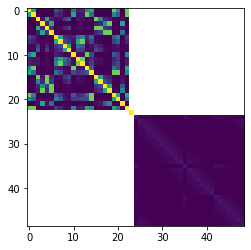

In [55]:
# build the prior; we are only doing this step to be able to look at this cool covariance matrix
# you could also record this to an external file if you really wanted to, but it is pretty huge due to the number of parameters
cov = pf.build_prior(fmt='none')

# and take a peak at a slice of the matrix
x = cov.x.copy()
x[x==0] = np.NaN
plt.imshow(x[-49:,-49:])

And now generate a prior parameter ensemble. This step is relevant for using pestpp-ies in subsequent tutorials.

In [56]:
pe = pf.draw(num_reals=100,use_specsim=True)# draw pars from the prior
pe.enforce() # enforces parameter bounds
pe.to_binary(os.path.join(template_ws,"prior.jcb")) #writes the paramter ensemble to binary file

# final tidy-up
pst.pestpp_options["ies_parameter_ensemble"] = "prior.jcb" #adds pest++ options to the control file
pst.write(os.path.join(template_ws, 'freyberg_mf6.pst')) # re-writes the control file with the new pest++ options

2022-03-15 15:51:50.533595 starting: drawing realizations


2022-03-15 15:51:50.777736 starting: spectral simulation for grid-scale pars
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72


2022-03-15 15:51:51.006280 starting: SpecSim: drawing 100 realization for group npf_k_layer1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-15 15:51:51.058077 finished: SpecSim: drawing 100 realization for group npf_k_layer1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.051797
2022-03-15 15:51:51.063065 starting: SpecSim: drawing 100 realization for group npf_k_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-15 15:51:51.110936 finished: SpecSim: drawing 100 realization for group npf_k_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.047871
2022-03-15 15:51:51.115924 starting: SpecSim: drawing 100 realization for group npf_k_layer3_gr with 706 pars, (log) variance 0.05428434

SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-15 15:51:51.238596 finished: SpecSim: drawing 100 realization for group npf_k33_layer1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.057846
2022-03-15 15:51:51.244580 starting: SpecSim: drawing 100 realization for group npf_k33_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-15 15:51:51.303422 finished: SpecSim: drawing 100 realization for group npf_k33_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.058842
2022-03-15 15:51:51.309406 starting: SpecSim: drawing 100 realization for group npf_k33_layer3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-15 15:51:51.366254 finished: SpecSim: drawing 100 realizati

2022-03-15 15:51:51.376229 starting: SpecSim: drawing 100 realization for group sto_ss_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-15 15:51:51.441054 finished: SpecSim: drawing 100 realization for group sto_ss_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.064825
2022-03-15 15:51:51.449034 starting: SpecSim: drawing 100 realization for group sto_ss_layer3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-15 15:51:51.516851 finished: SpecSim: drawing 100 realization for group sto_ss_layer3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.067817
2022-03-15 15:51:51.523833 starting: SpecSim: drawing 100 realization for group sto_sy_layer1_gr with 706 pars, (log) variance 0.054

2022-03-15 15:51:51.591651 starting: SpecSim: drawing 100 realization for group rch_recharge_1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-15 15:51:51.657476 finished: SpecSim: drawing 100 realization for group rch_recharge_1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.065825
2022-03-15 15:51:51.664457 starting: SpecSim: drawing 100 realization for group rch_recharge_10_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-15 15:51:51.732762 finished: SpecSim: drawing 100 realization for group rch_recharge_10_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.068305
2022-03-15 15:51:51.738745 starting: SpecSim: drawing 100 realization for group rch_recharge_11_gr with 706 pars, (log) varian

2022-03-15 15:51:51.807800 finished: SpecSim: drawing 100 realization for group rch_recharge_11_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.069055
2022-03-15 15:51:51.812786 starting: SpecSim: drawing 100 realization for group rch_recharge_12_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-15 15:51:51.871628 finished: SpecSim: drawing 100 realization for group rch_recharge_12_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.058842
2022-03-15 15:51:51.877612 starting: SpecSim: drawing 100 realization for group rch_recharge_13_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-15 15:51:51.936961 finished: SpecSim: drawing 100 realization for group rch_recharge_13_gr with 706 pars, (log) vari

2022-03-15 15:51:52.004249 starting: SpecSim: drawing 100 realization for group rch_recharge_15_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-15 15:51:52.060092 finished: SpecSim: drawing 100 realization for group rch_recharge_15_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.055843
2022-03-15 15:51:52.065079 starting: SpecSim: drawing 100 realization for group rch_recharge_16_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-15 15:51:52.131901 finished: SpecSim: drawing 100 realization for group rch_recharge_16_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.066822
2022-03-15 15:51:52.137885 starting: SpecSim: drawing 100 realization for group rch_recharge_17_gr with 706 pars, (log) vari

2022-03-15 15:51:52.211689 starting: SpecSim: drawing 100 realization for group rch_recharge_18_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-15 15:51:52.283750 finished: SpecSim: drawing 100 realization for group rch_recharge_18_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.072061
2022-03-15 15:51:52.288737 starting: SpecSim: drawing 100 realization for group rch_recharge_19_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-15 15:51:52.354561 finished: SpecSim: drawing 100 realization for group rch_recharge_19_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.065824
2022-03-15 15:51:52.360546 starting: SpecSim: drawing 100 realization for group rch_recharge_2_gr with 706 pars, (log) varia

2022-03-15 15:51:52.424374 starting: SpecSim: drawing 100 realization for group rch_recharge_20_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-15 15:51:52.480225 finished: SpecSim: drawing 100 realization for group rch_recharge_20_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.055851
2022-03-15 15:51:52.485211 starting: SpecSim: drawing 100 realization for group rch_recharge_21_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-15 15:51:52.548050 finished: SpecSim: drawing 100 realization for group rch_recharge_21_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.062839
2022-03-15 15:51:52.556029 starting: SpecSim: drawing 100 realization for group rch_recharge_22_gr with 706 pars, (log) vari

2022-03-15 15:51:52.636814 finished: SpecSim: drawing 100 realization for group rch_recharge_22_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.080785
2022-03-15 15:51:52.643795 starting: SpecSim: drawing 100 realization for group rch_recharge_23_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-15 15:51:52.712609 finished: SpecSim: drawing 100 realization for group rch_recharge_23_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.068814
2022-03-15 15:51:52.719591 starting: SpecSim: drawing 100 realization for group rch_recharge_24_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-15 15:51:52.787409 finished: SpecSim: drawing 100 realization for group rch_recharge_24_gr with 706 pars, (log) vari

2022-03-15 15:51:52.863207 finished: SpecSim: drawing 100 realization for group rch_recharge_25_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.069810
2022-03-15 15:51:52.871185 starting: SpecSim: drawing 100 realization for group rch_recharge_3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-15 15:51:52.935017 finished: SpecSim: drawing 100 realization for group rch_recharge_3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.063832
2022-03-15 15:51:52.941997 starting: SpecSim: drawing 100 realization for group rch_recharge_4_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-15 15:51:53.004831 finished: SpecSim: drawing 100 realization for group rch_recharge_4_gr with 706 pars, (log) variance

2022-03-15 15:51:53.070019 finished: SpecSim: drawing 100 realization for group rch_recharge_5_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.058208
2022-03-15 15:51:53.074641 starting: SpecSim: drawing 100 realization for group rch_recharge_6_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-15 15:51:53.127499 finished: SpecSim: drawing 100 realization for group rch_recharge_6_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.052858
2022-03-15 15:51:53.132487 starting: SpecSim: drawing 100 realization for group rch_recharge_7_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-15 15:51:53.180358 finished: SpecSim: drawing 100 realization for group rch_recharge_7_gr with 706 pars, (log) variance 

2022-03-15 15:51:53.282086 finished: SpecSim: drawing 100 realization for group rch_recharge_9_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.046875
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72


2022-03-15 15:51:53.549771 finished: spectral simulation for grid-scale pars took: 0:00:02.772035
2022-03-15 15:51:53.550769 starting: Drawing non-specsim pars
building diagonal cov


processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

working on pargroups ['npf_k_layer1_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['npf_k_layer2_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['npf_k_layer3_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['npf_k33_layer1_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['npf_k33_layer2_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['npf_k33_layer3_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['sto_ss_layer2_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['sto_ss_layer3_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['sto_sy_layer1_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_1_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_10_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_11_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_12_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_13_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_14_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_15_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_16_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_17_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_18_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_19_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_2_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_20_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_21_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_22_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_23_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_24_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_25_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_3_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_4_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_5_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_6_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_7_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_8_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_9_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['ghbcond_gr']


build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['ghbcond_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov


working on pargroups ['ghbcond_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['sfrcond_gr']
build cov matrix
done
getting diag var cov 40
scaling full cov by diag var cov


processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0

working on pargroups ['wel_cst']
build cov matrix
done
getting diag var cov 25
scaling full cov by diag var cov
working on pargroups ['sfr_gr']
build cov matrix
done
getting diag var cov 25
scaling full cov by diag var cov


processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

working on pargroups ['ghbhead_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['ghbhead_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['ghbhead_gr']


build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
adding remaining parameters to diagonal


2022-03-15 15:52:03.260641 finished: Drawing non-specsim pars took: 0:00:09.709872


2022-03-15 15:52:05.511996 finished: drawing realizations took: 0:00:14.978401


noptmax:0, npar_adj:25454, nnz_obs:920
